# 0.0 IMPORTS

In [1]:
import psycopg2
import inflection

import pandas                  as pd
import seaborn                 as sns
import numpy                   as np
import scikitplot              as skplt
import matplotlib.pyplot       as plt
import boruta                  as bt
import xgboost                 as xgb
import random                  as rd
import pickle
import os

from sklearn.model_selection   import train_test_split, StratifiedKFold
from lightgbm                  import LGBMClassifier
from sklearn.naive_bayes       import GaussianNB
from psycopg2                  import Error
from sklearn.ensemble          import ExtraTreesClassifier, RandomForestRegressor
from tabulate                  import tabulate
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split
from IPython.display           import Image
from IPython.core.display      import HTML
from boruta                    import BorutaPy
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import StratifiedShuffleSplit as sss

from sklearn                   import metrics            as m
from sklearn                   import neighbors          as nh
from sklearn                   import ensemble           as en
from sklearn                   import model_selection    as ms
from scipy                     import stats              as ss

##  Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# precision_at_k
def precision_at_k_(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k_(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']


def model_results (model_ml, model_name, df, k ):
    
    precision_list = []
    recall_list = []
    
    #prediction
    yhat_proba_model = model_ml.predict_proba(x_validation)

    # copy dataframe
    df = x_validation.copy()
    df['response'] = y_validation.copy()

    # propensity score
    df['score'] = yhat_proba_model[:, 1].tolist()

    # sort clients by propensity score
    df = df.sort_values( 'score', ascending=False )

    # compute precision at k 
    precision_model = precision_at_k_( df, k )
    
    # compute recall at k
    recall_model = recall_at_k_( df, k )
    
    precision_list.append(precision_model)
    recall_list.append(recall_model)

    # plot
    fig, axs = plt.subplots(ncols= 2, figsize = (12,6));
    skplt.metrics.plot_cumulative_gain(Y_vali, yhat_proba_model, ax=axs[0],title='Cumulative Gain Curve');
    skplt.metrics.plot_lift_curve(Y_vali, yhat_proba_model,ax=axs[1],title='Lift Curve');
    
    # dataframe
    model_rank = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
    
    new_row = {'Model': model_name, 
               'Precision_at_k': precision_model,
               'Recall_at_k': recall_model}
            
    model_rank = model_rank.append(new_row, ignore_index = True)
    return model_rank

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
####-------------------------------------------------------------------------------------------------------------------------------------------------------



def precision_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()  
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def cross_validation(data, models_performance, num_folds, model_name, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    
    
    i=1
    for train_cv,val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        precision_list.append(precision)
        
        recall = round(recall_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        recall_list.append(recall)
        
        
        
                
        i+=1
    
    precision_str = np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str)
    recall_str    = np.round(np.mean(recall_list), 3).astype(str)    + ' +/- ' + np.round(np.std(recall_list), 3)   .astype(str)
    models_performance = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
        
    models_performance = models_performance.append(pd.Series([model_name, precision_str, recall_str], index = models_performance.columns), ignore_index = True)

    return models_performance



Populating the interactive namespace from numpy and matplotlib


##  Get Data from Database

In [3]:
#HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
#PORT = '5432'
#DATABASE = 'comunidadedsdb'
#USER = 'member'
#PASSWORD ='cdspa'

# # Connect to an existing database
# connection = psycopg2.connect(user="member",
#                               password="cdspa",
#                               host="comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com",
#                               port="5432",
#                               database="comunidadedsdb")
# # create a cursor
# cursor = connection.cursor()
# query = """
#             SELECT *
#                FROM pa004.users pu 
#                INNER JOIN pa004.vehicle pv 	 ON pv.id = pu.id 
#                INNER JOIN pa004.insurance pi ON pi.id = pu.id
#                ORDER BY pu.id """

# cursor.execute(query)
# print("Selecting rows from pa004 table using cursor.fetchall ended")
# pa_records = cursor.fetchall()

# df = pd.read_sql(query,connection)  
    
# # close the connection
# connection.close()
# df = df.drop (df.columns[[5,9]], axis = 1)
# df.head()


#df.to_csv('C:/Users/Djalma.junior/DS/PA4/dataset/train.csv', index = False)

##  Load dataset

In [4]:
df_raw = pd.read_csv ('C:/Users/Djalma.junior/DS/PA4/dataset/train.csv')

#  1.0 DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Descriptive Statistics

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.5.1. Numerical Atributes

In [11]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,381108.0,381108.0,190554.000000,190554.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [12]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

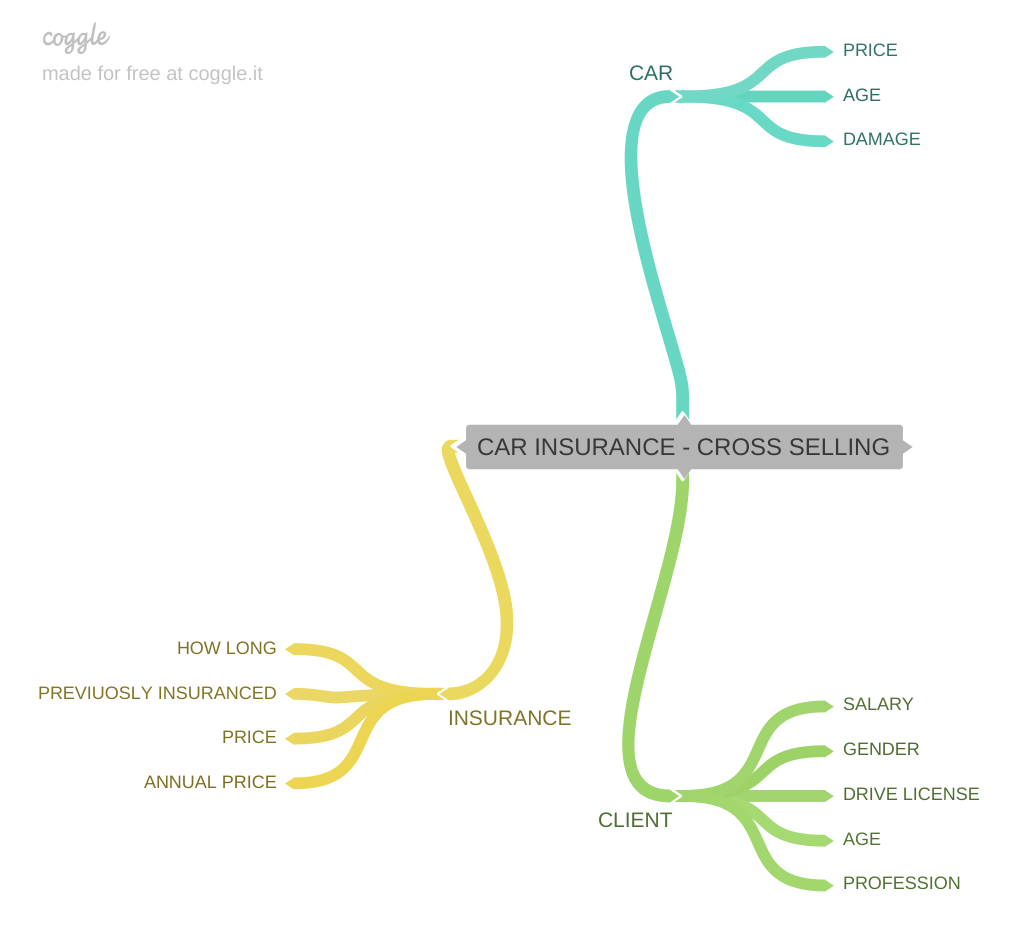

In [13]:
Image ('IMG/CAR_INSURANCE_CROSS_SELLING.png')

###  2.2.1 Customer Hypotheses







1. Mulheres estão mais propensas a contratar seguros de carro.
2. Quanto maior a idade, maior a possibilidade de contratar um seguro de carro.
3. O local de residência influi na decisão de contratar um seguro de carro.
4. Pessoas casadas possuem maior tendência de contratar um seguro de carro.
5. Pessoas com filhos possuem maior tendência de contratar um seguro de carro.




### 2.2.2 Vehicle Hypotheses

1. Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.
2. Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.
3. Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.
4. Pessoas que utilizam o carro de maneira mais frequente tem maior tendência a contratar um seguro de carro.

### 2.2.3 Insurance Company Hypotheses

1. Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.
2. Clientes com gastos mais elevados em seguros de saúde tem maior tendência em contratar um novo produto.
3. O canal de comunicação utilizado para realizar a oferta influí na aceitação do novo produto.  

###  2.3 Hypotheses Final List

1. Mulheres estão mais propensas a contratar seguros de carro.
2. Quanto maior a idade, maior a possibilidade de contratar um seguro de carro.
3. O local de residência influi na decisão de contratar um seguro de carro.
4. Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.
5. Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.
6. Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.
7. Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.

## 2.2. Feature Engineering


In [14]:
df2 ['vehicle_damage'] = df2['vehicle_damage'].apply (lambda x : 1 if x == 'Yes' else 0 ).astype(int64)

In [15]:
df2 ['vehicle_age'] = df2 ['vehicle_age'].apply (lambda x: 'less_1_year'   if x == '< 1 Year'  else  'btw_1_2_years'    if x == '1-2 Year'    else 'over_2_years') 


#  3.0 FILTRAGEM DE VARIÁVEIS



In [16]:
df3 = df2.copy()

# 4.0 ANALISE EXPLORATORIA DOS DADOS

In [17]:
df4 = df3.copy()

## 4.1. Analise Univariada

In [18]:
# como a maioria das variaveis nao tem um nivel de correlacao forte por se trata de uma venda cross selling a EDA segue apenas com a analise univariada
# que por sua vez tem o papel de mostrar min max distribuicao e range da variavel , mostrando assim seu comportamento.

### 4.1.1 Age

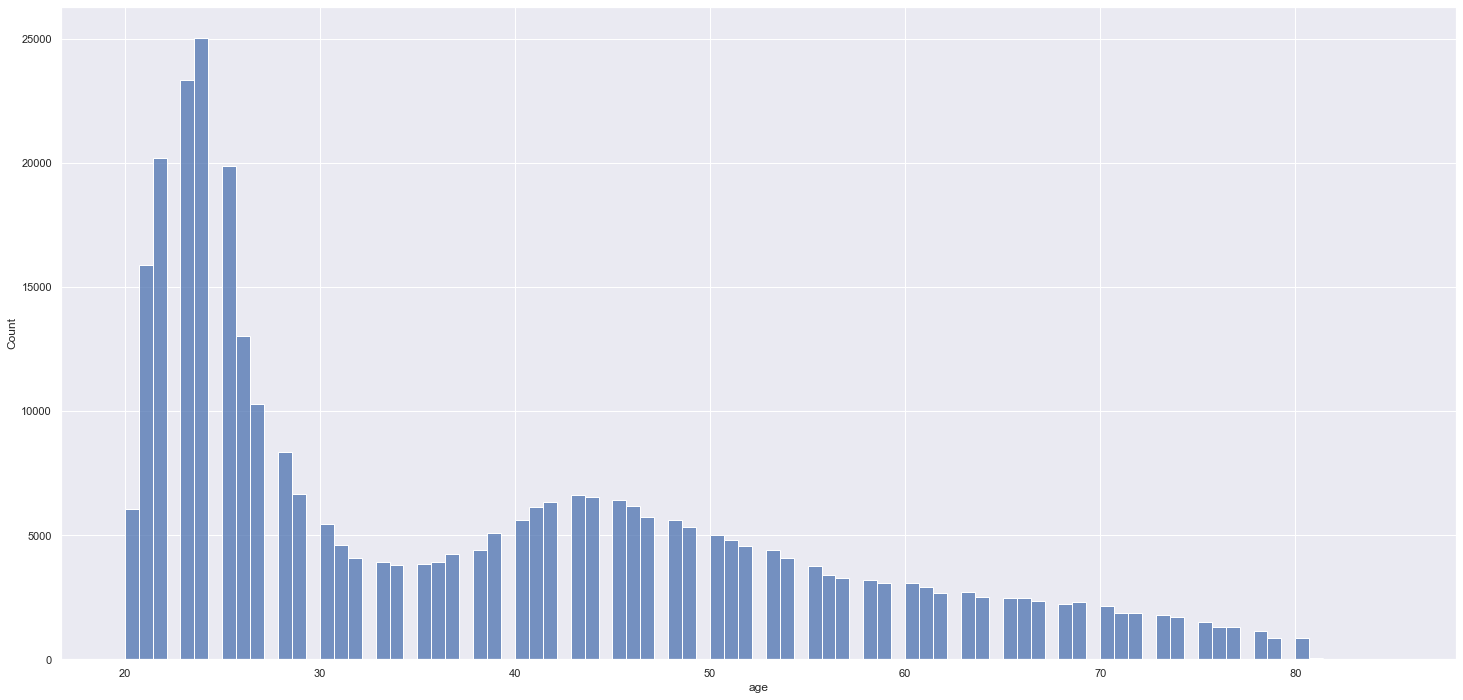

In [19]:
aux1 = df4.loc[df4['response']==0,'age']
sns.histplot(aux1);
#kde=False se nao quiser ver os quadrados no background

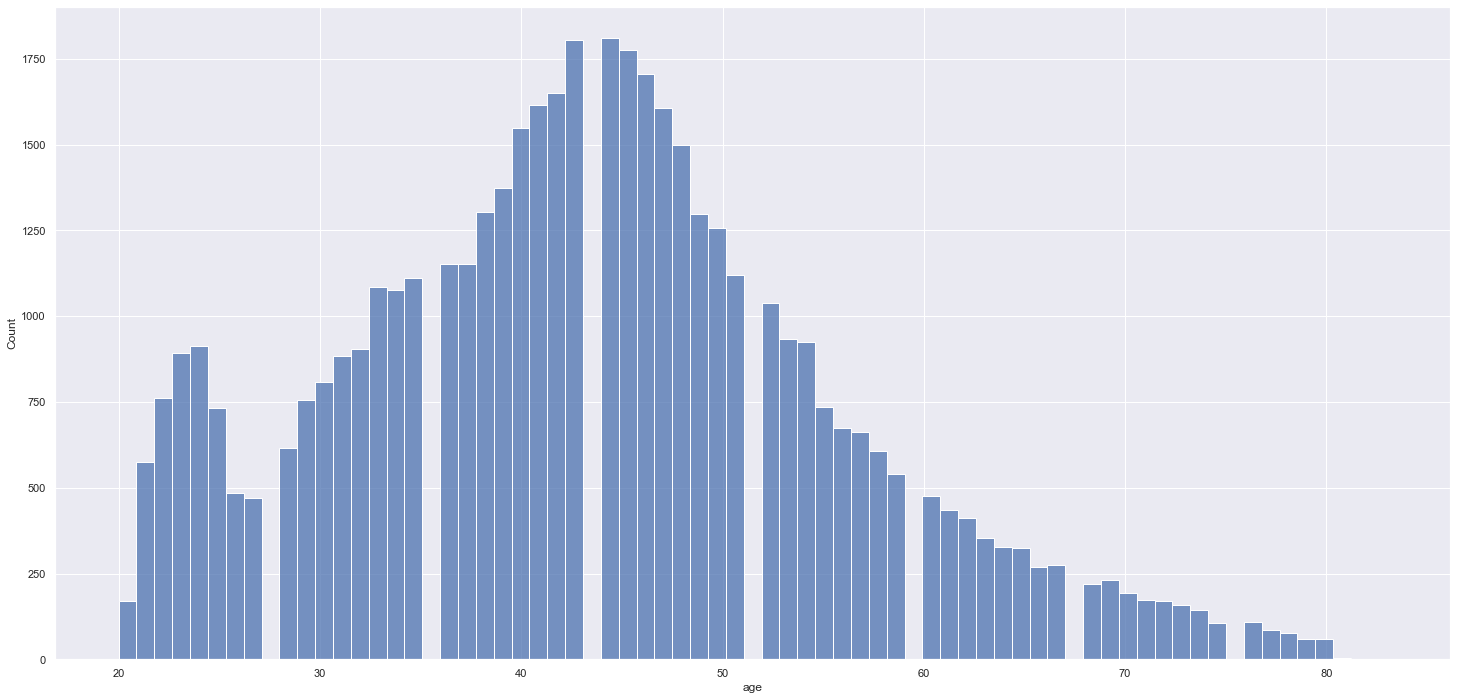

In [20]:
aux2 = df4.loc[df4['response']==1,'age']
sns.histplot(aux2);

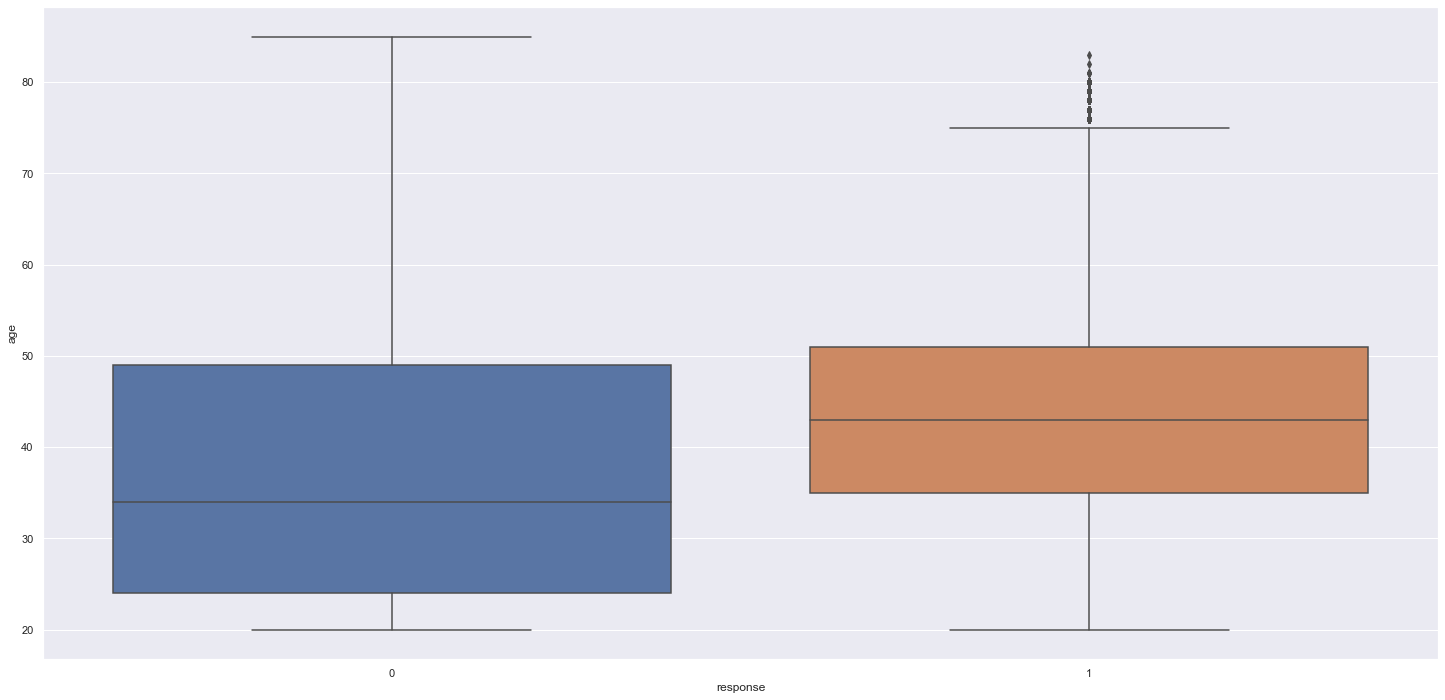

In [21]:
sns.boxplot(x='response', y='age', data=df4);
# aqui eh possivel ver melhor onde esta a mediana de pessoas que responderam sim pela idade

### 4.1.2 Driving License

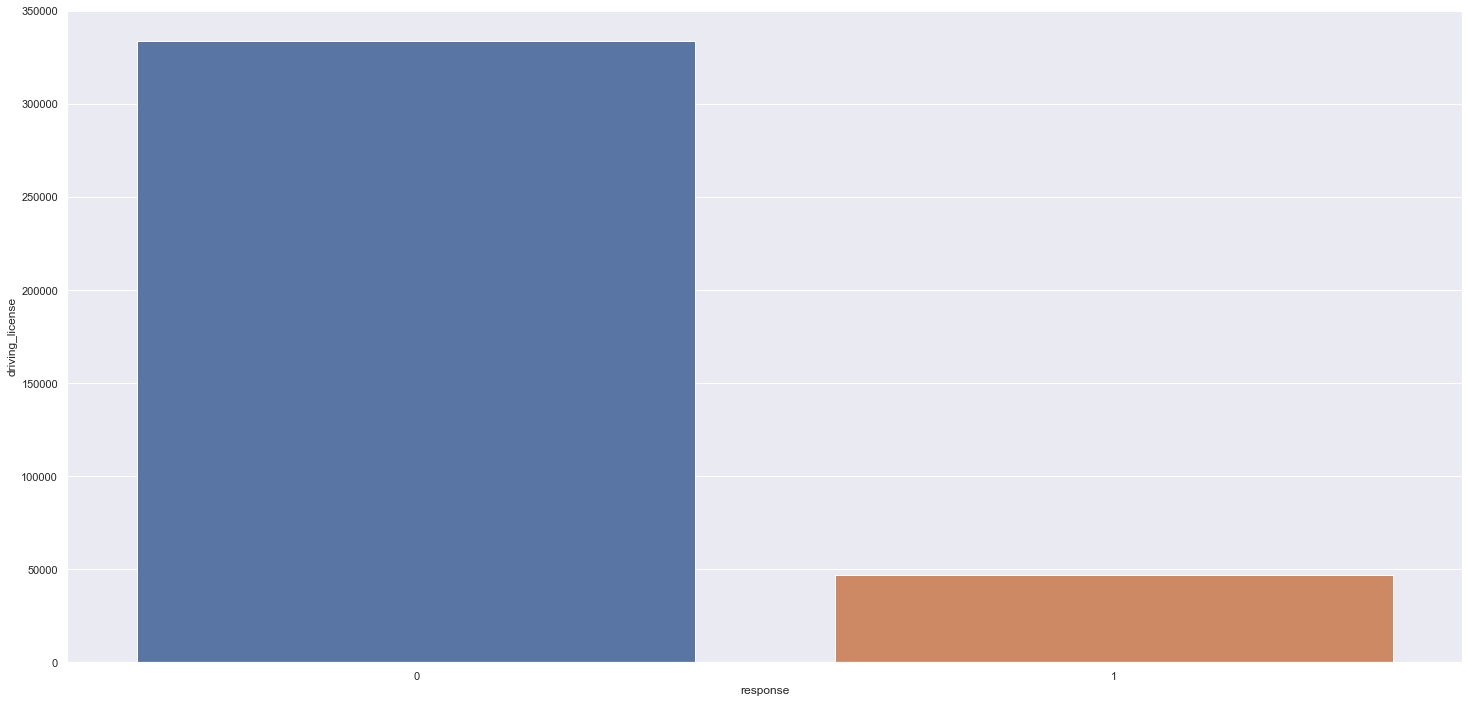

In [22]:
aux4 = df4[['response','driving_license']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux4 );

In [23]:
aux4['driving_license_perce']=aux4['driving_license']/aux4['driving_license'].sum()
aux4.head()

,response,driving_license,driving_license_perce
0,0,333628,0.877283
1,1,46669,0.122717


### 4.1.3 Region Code

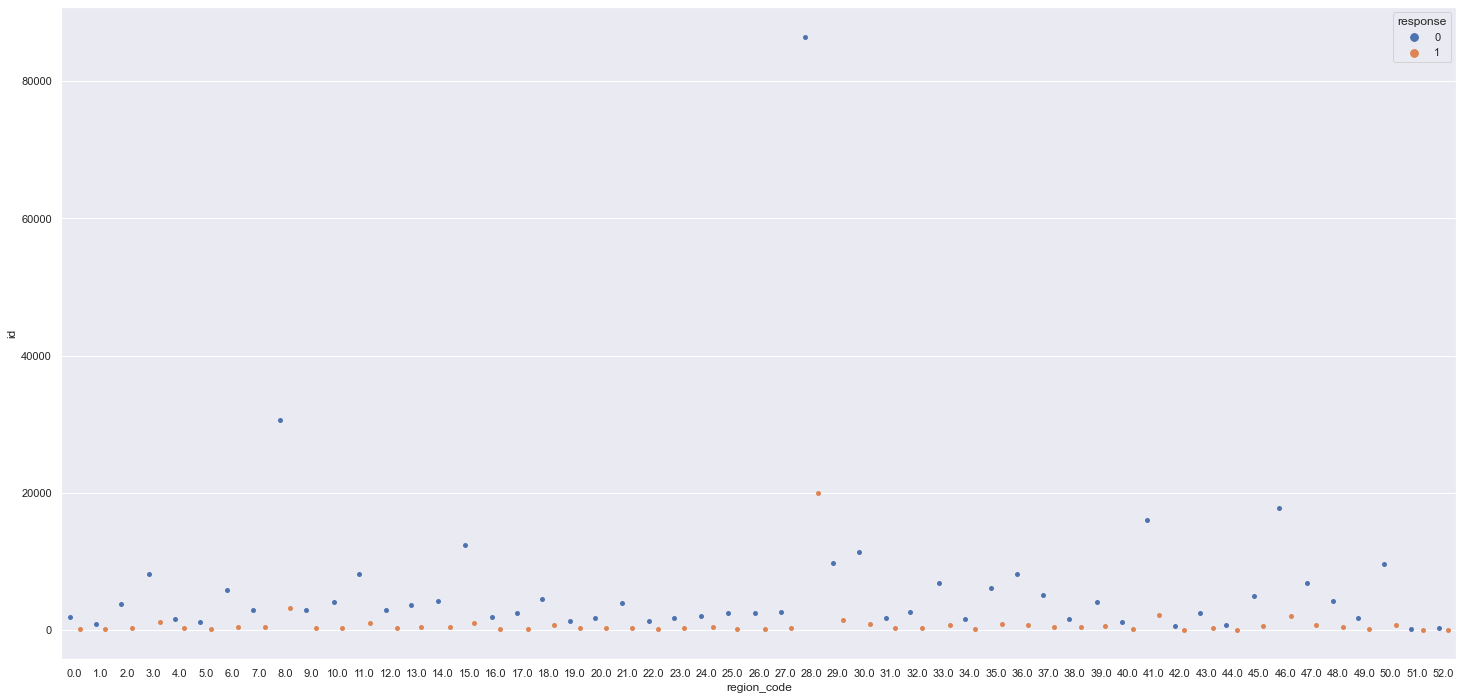

In [24]:
# se usar o id .sum o eixo y fica com exponencial 1e10 por isso usado count


aux5= df4[['id', 'region_code','response']].groupby(['response','region_code']).count().reset_index()
sns.stripplot(x='region_code', y='id', data=aux5, hue='response', dodge=True);



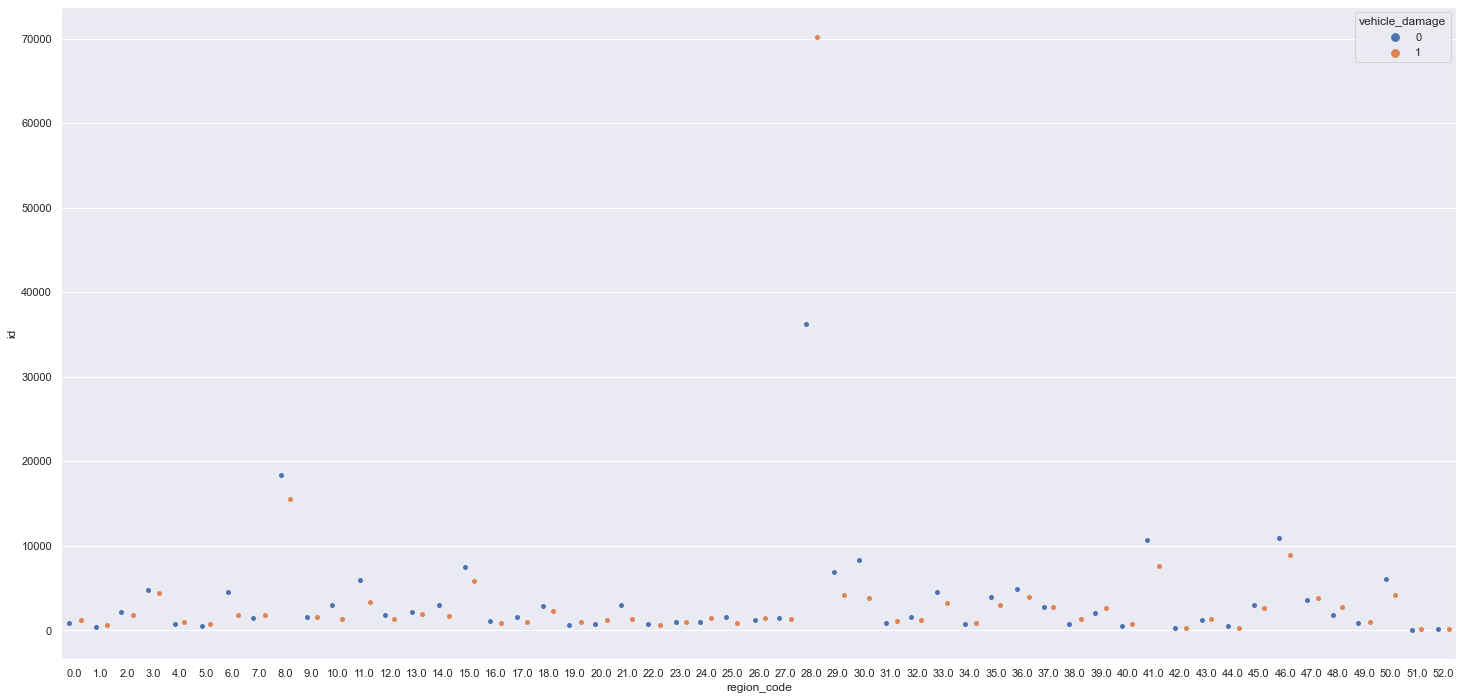

In [25]:
aux5= df4[['id', 'region_code','vehicle_damage']].groupby(['vehicle_damage','region_code']).count().reset_index()
sns.stripplot(x='region_code', y='id', data=aux5, hue='vehicle_damage', dodge=True);

#onde tem mais carro batido tem mais resposta sim

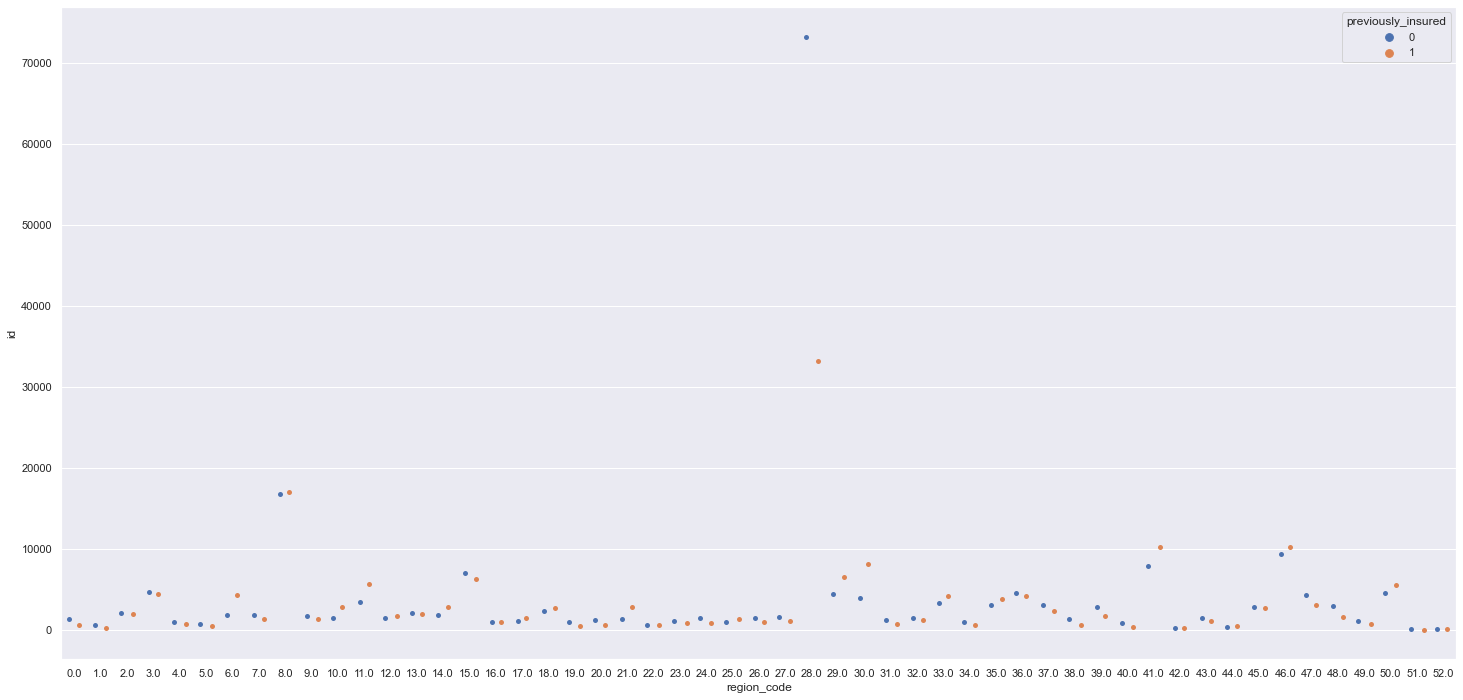

In [26]:
aux5= df4[['id', 'region_code','previously_insured']].groupby(['previously_insured','region_code']).count().reset_index()
sns.stripplot(x='region_code', y='id', data=aux5, hue='previously_insured', dodge=True);


### 4.1.4 Previously Insured

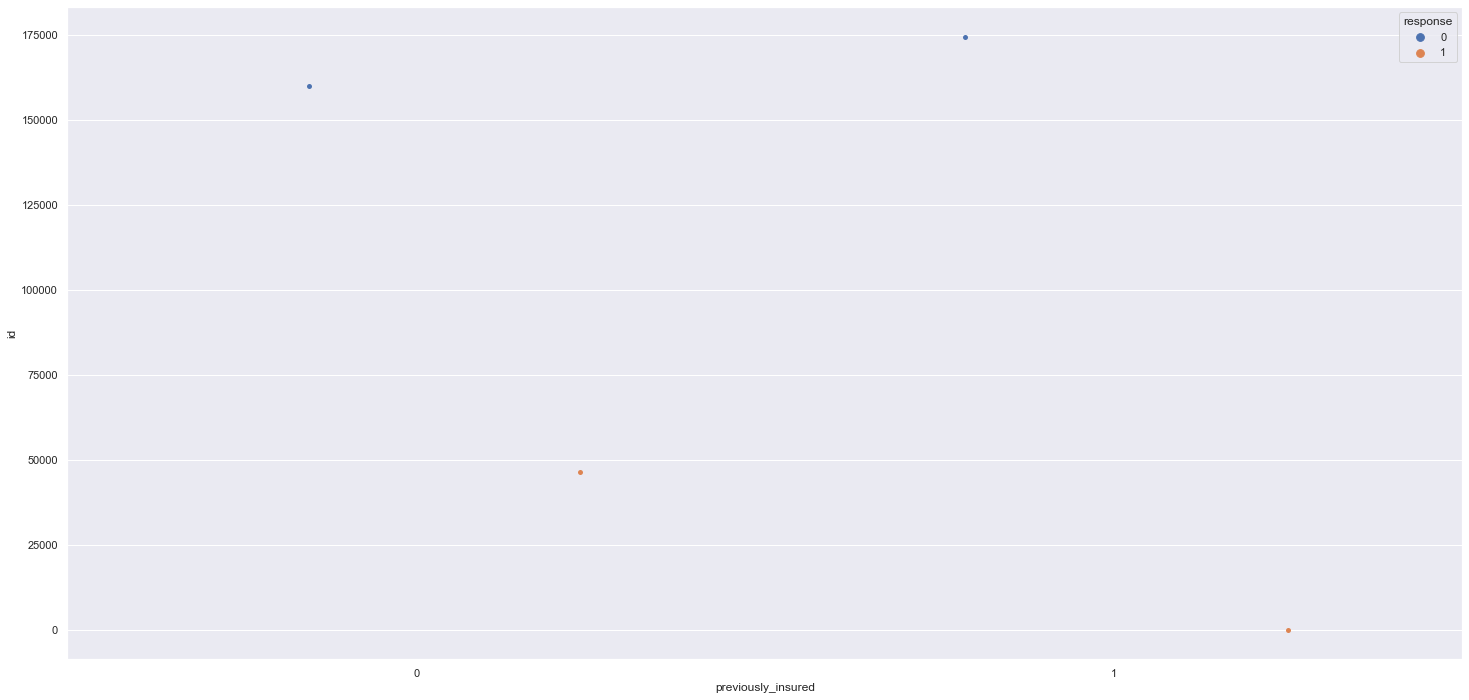

In [27]:
aux6=df4[['id','previously_insured','response']].groupby(['previously_insured','response']).count().reset_index()
sns.stripplot(x='previously_insured', y='id', data=aux6, hue='response', dodge=True);
                                                          
    


In [28]:
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x/x.sum(),axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.5  Vehicle Age

In [29]:
df4[['id', 'vehicle_age', 'response']].groupby(['vehicle_age', 'response']).count().reset_index()

,vehicle_age,response,id
0,btw_1_2_years,0,165510
1,btw_1_2_years,1,34806
2,less_1_year,0,157584
3,less_1_year,1,7202
4,over_2_years,0,11305
5,over_2_years,1,4702


In [30]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,btw_1_2_years,0,0.434285
1,less_1_year,0,0.413488
2,btw_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,less_1_year,1,0.018897
5,over_2_years,1,0.012338


### 4.1.6 Vehicle Damage

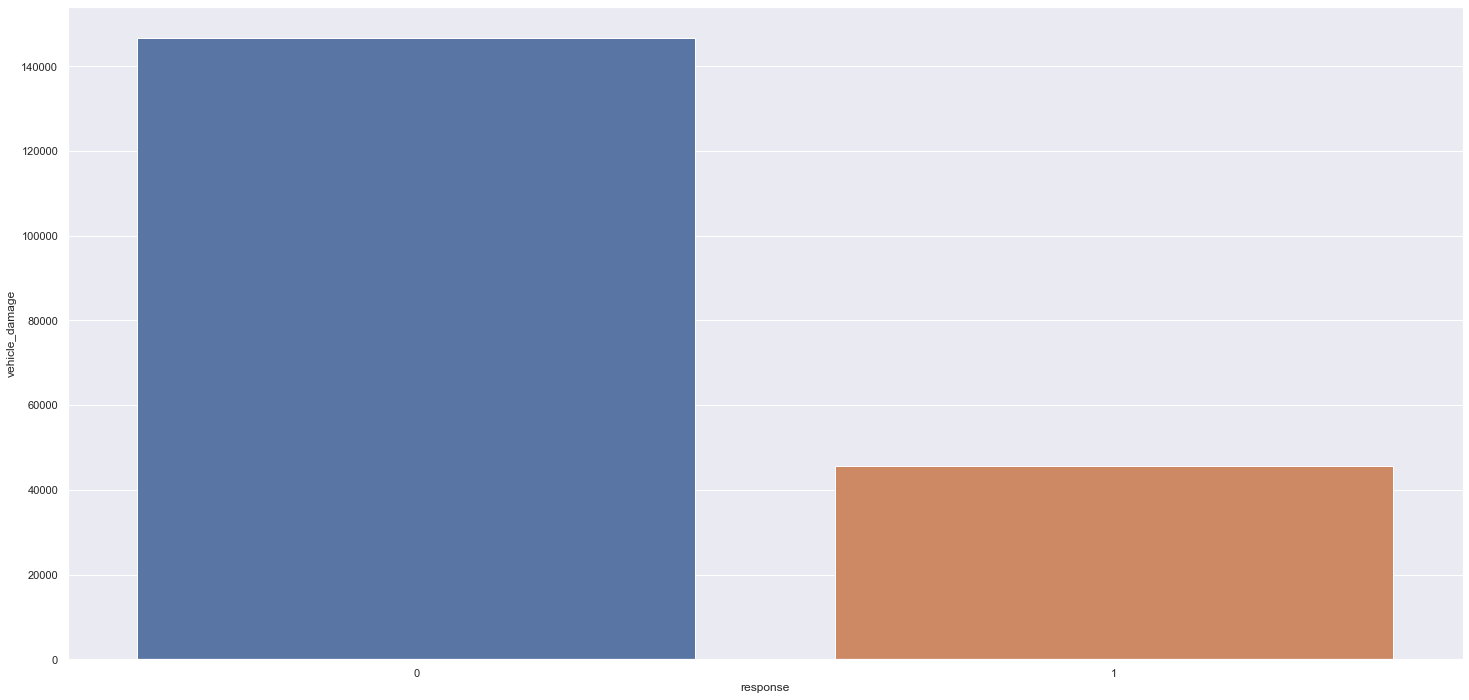

In [31]:
aux6 = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='vehicle_damage', data=aux6);


### 4.1.7 Annual Premium

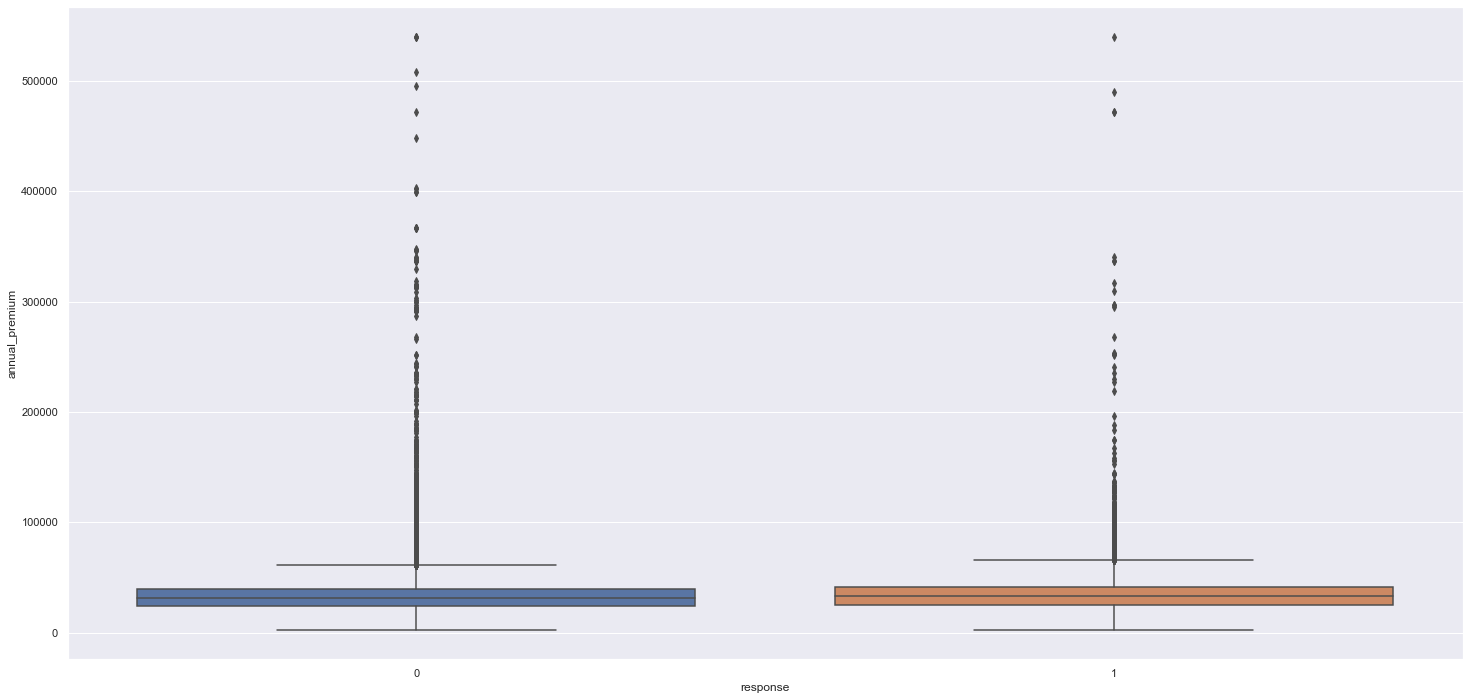

In [32]:
sns.boxplot(x='response', y='annual_premium', data=df4);

### 4.1.8 Policy sales channel 

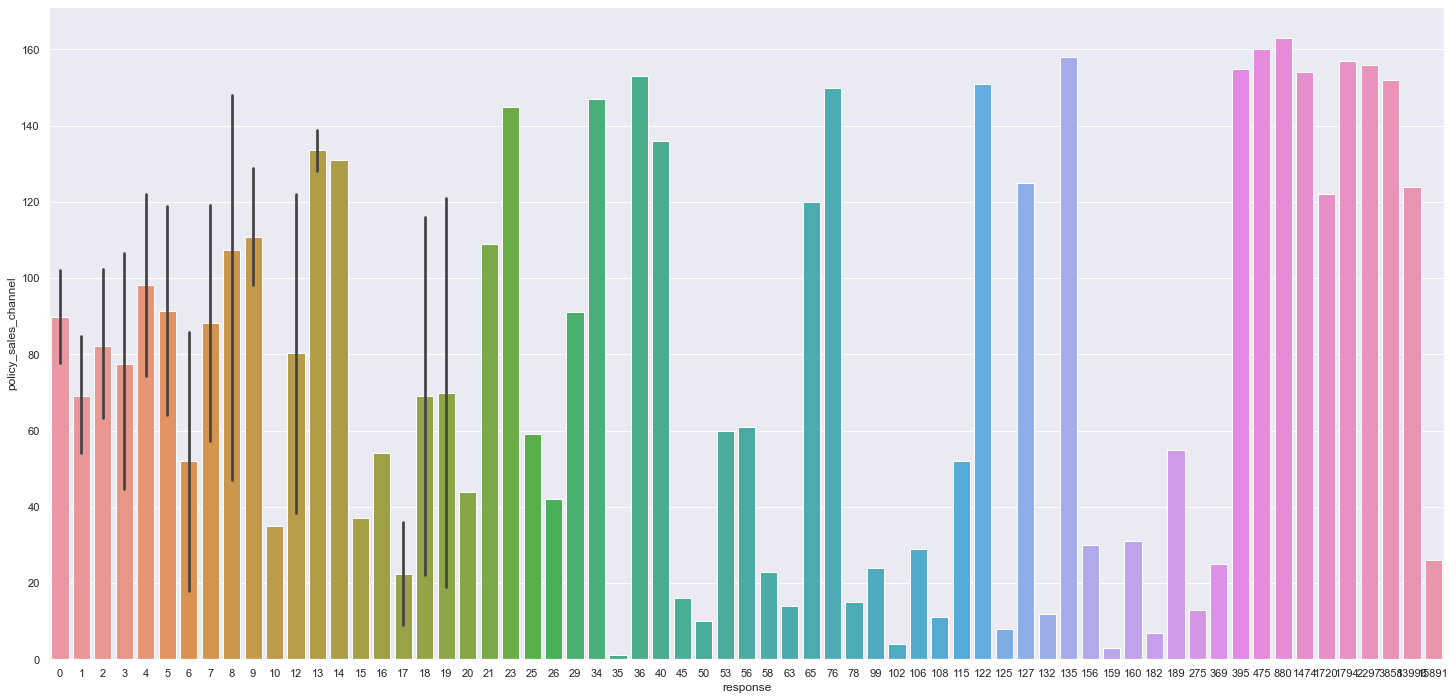

In [33]:
aux10 = df4 [['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux10);


### 4.1.9 Vintage

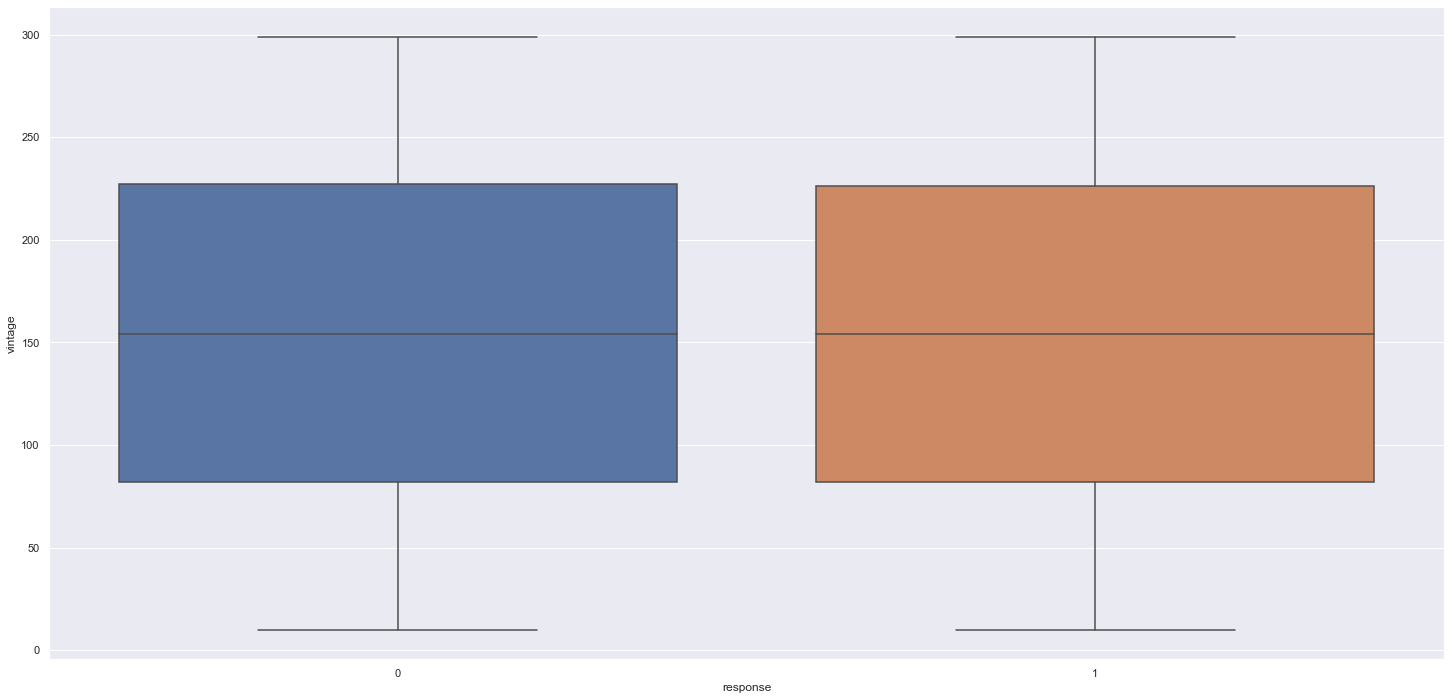

In [34]:
sns.boxplot(x='response', y='vintage', data=df4);

### 4.1.10 Numerical Variables

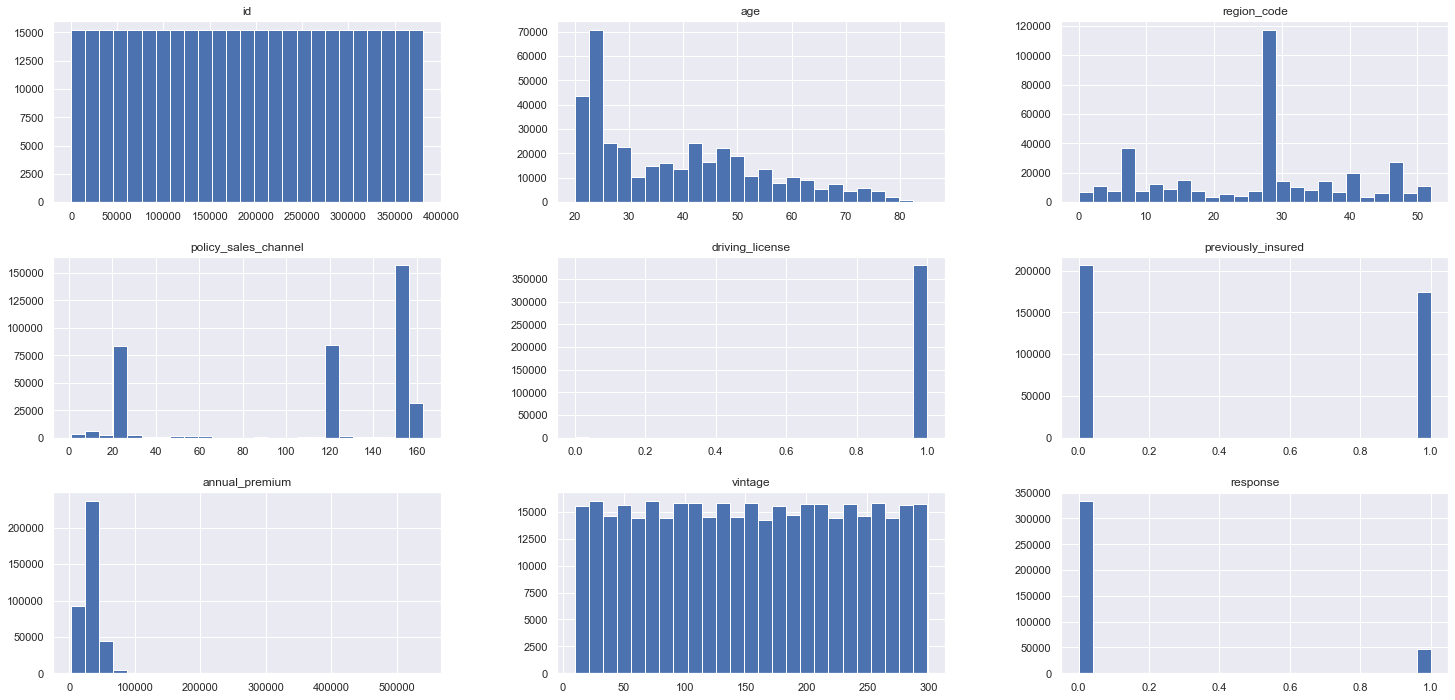

In [35]:
num_attributes.hist(bins=25);

### 4.1.11 Categorical Variables

In [36]:
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


## 4.2 Analise Bivariada


### **H1.** Mulheres estão mais propensas a contratar seguros de carro.


**FALSE** Homens estão mais propensos a contratar seguros de carro

In [37]:
aux40 = df4[['id','gender','response']].groupby(['gender','response']).count().reset_index()
aux40.head()

,gender,response,id
0,Female,0,156835
1,Female,1,18185
2,Male,0,177564
3,Male,1,28525


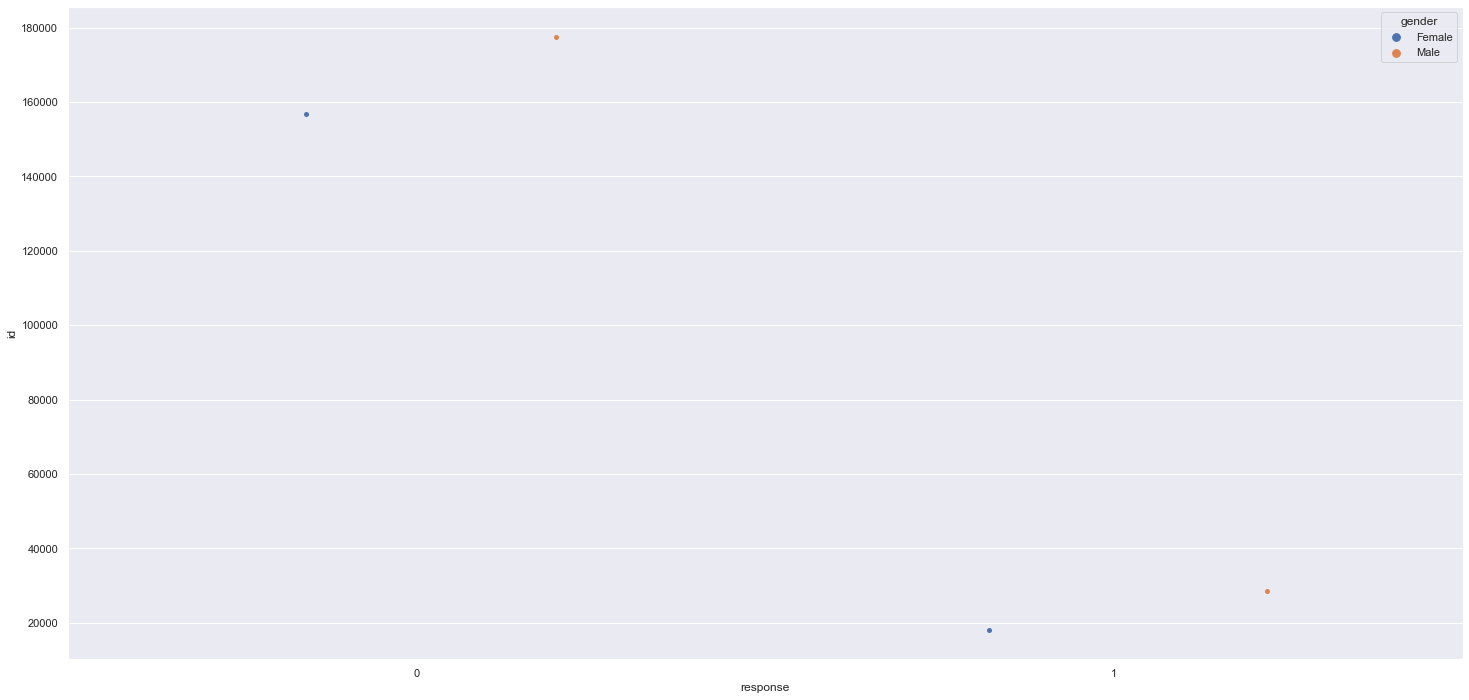

In [38]:
sns.stripplot(x='response', y='id', data=aux40, hue='gender', dodge=True);

### **H2.** A Faixa de Meia-idade tem maior a possibilidade de contratar um seguro de carro.


**TRUE** Meia-idade tem maior a possibilidade de contratar

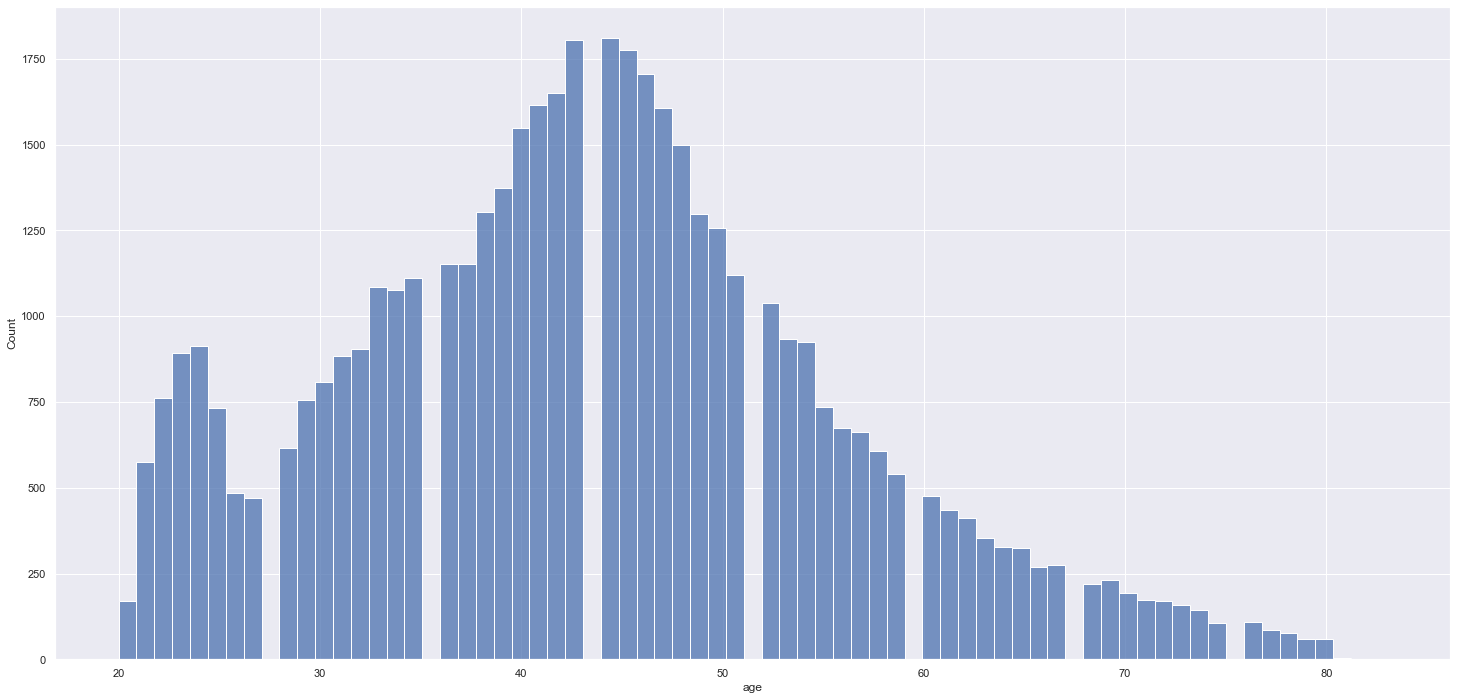

In [39]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 );

### **H3.** O local de residência influi na decisão de contratar um seguro de carro.


**TRUE** O local de residência influi

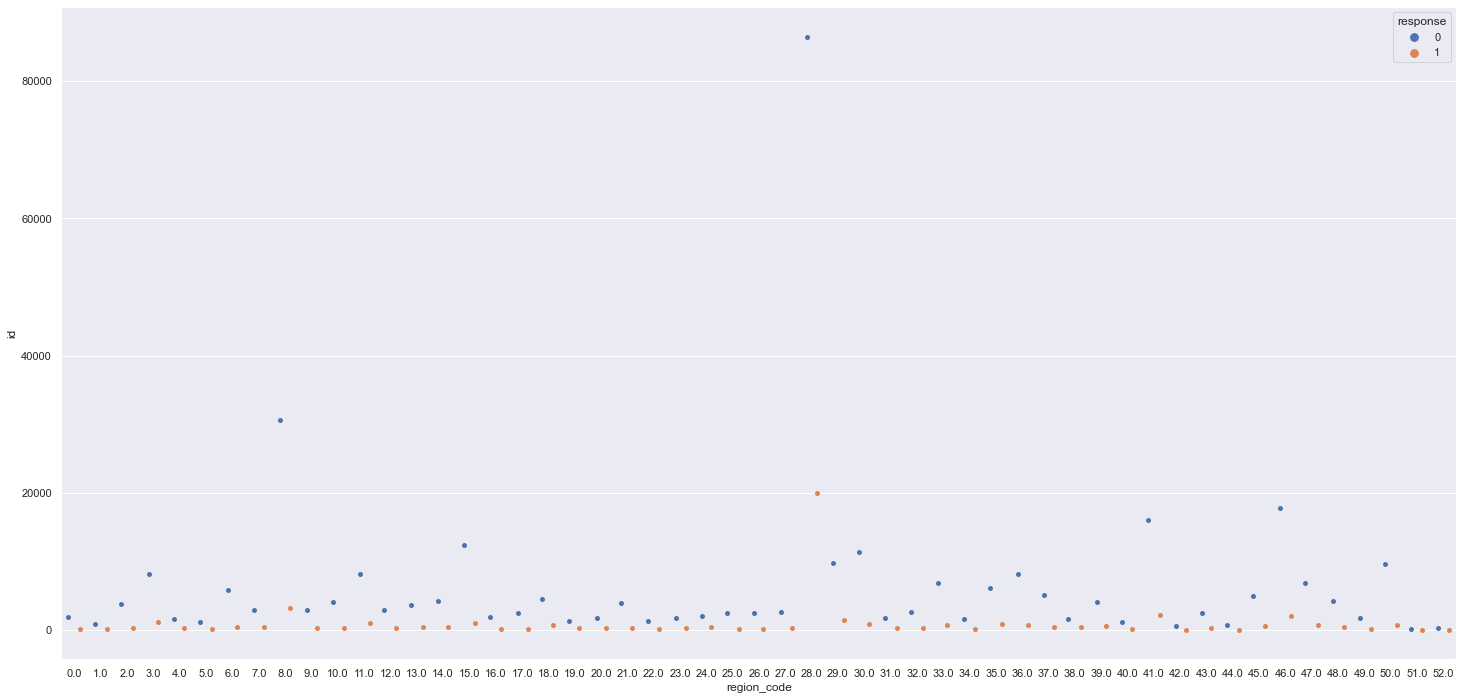

In [40]:
aux00= df4[['id', 'region_code','response']].groupby(['response','region_code']).count().reset_index()
sns.stripplot(x='region_code', y='id', data=aux00, hue='response', dodge=True);

### **H4.** Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.


**TRUE** Pessoas que já tiveram danos em seus carros TENDEM  a contratar

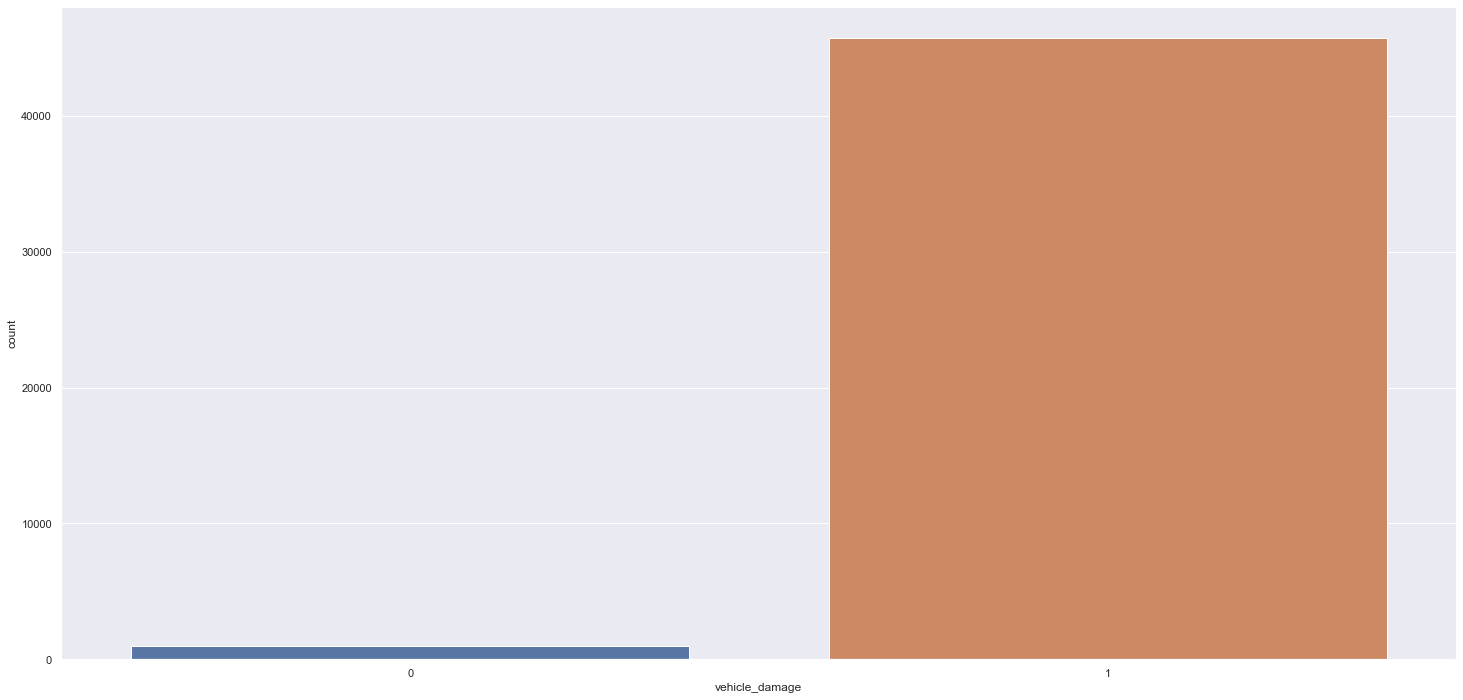

In [41]:
aux = df4[df4['response'] == 1]
sns.countplot(data = aux, x = 'vehicle_damage');

### **H5.** Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.


**FALSE** Pessoas que a já possuem seguro nao querem uma nova apolice

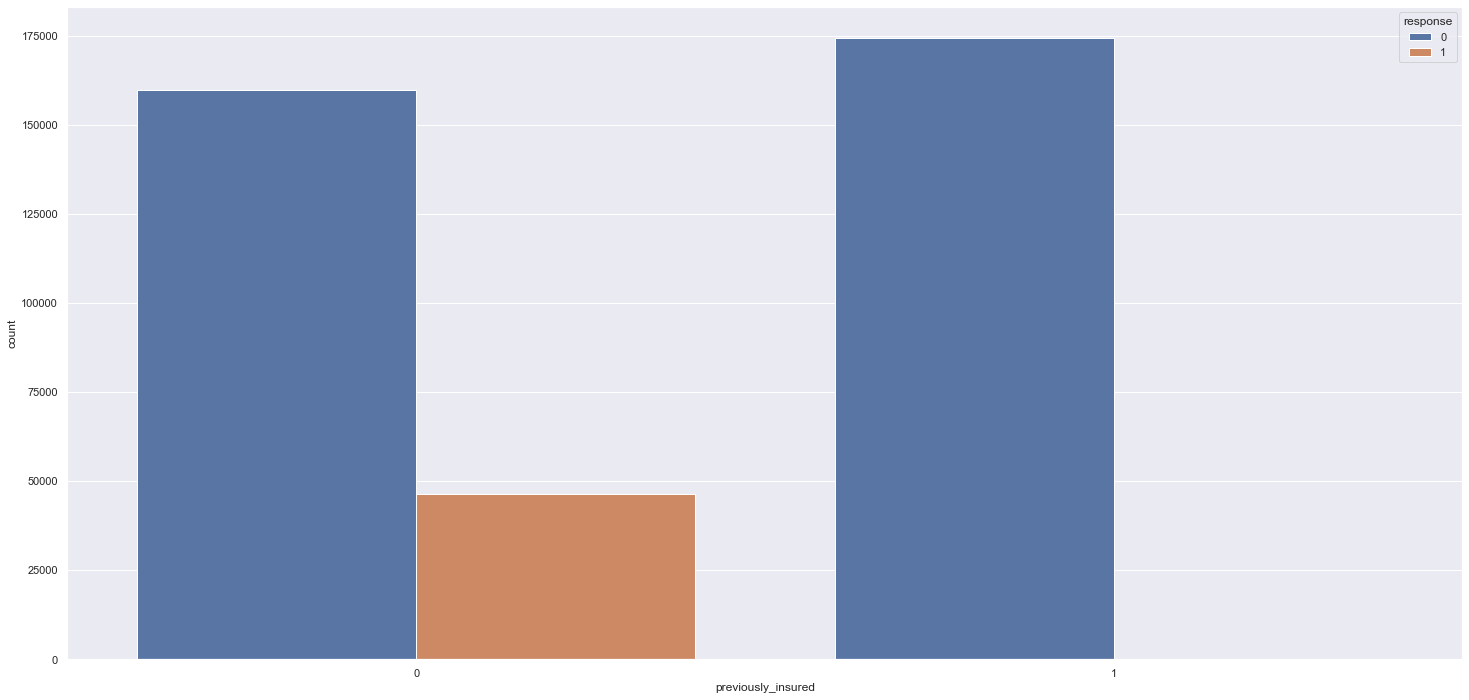

In [42]:
sns.countplot(data = df4, x = 'previously_insured', hue = 'response');

### **H6.** Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.


**FALSE** Pessoas com veículos ENTRE 1 E 2 ANOS tendem a contratar

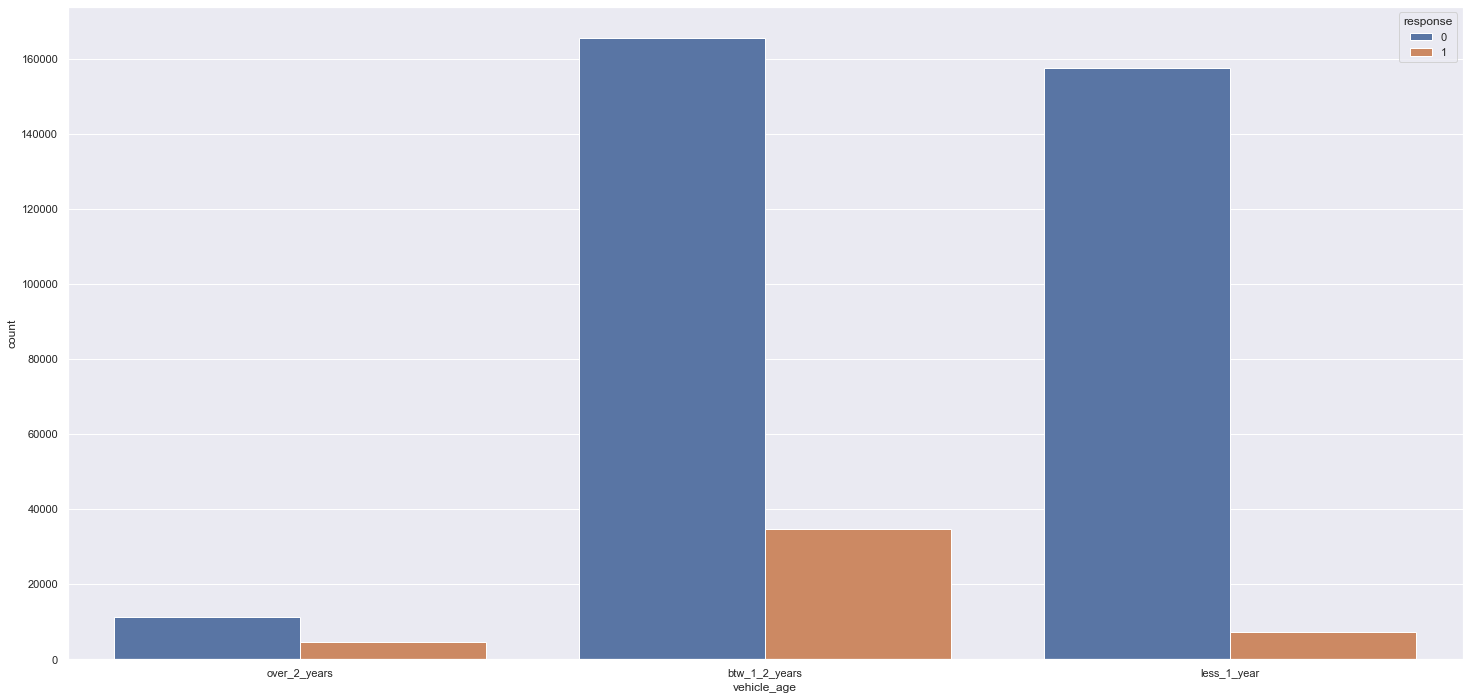

In [43]:
sns.countplot(data = df4, x = 'vehicle_age', hue = 'response');

### **H7.** Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.


**FALSE** O numero se mantem na media

<AxesSubplot:xlabel='vintage', ylabel='Count'>

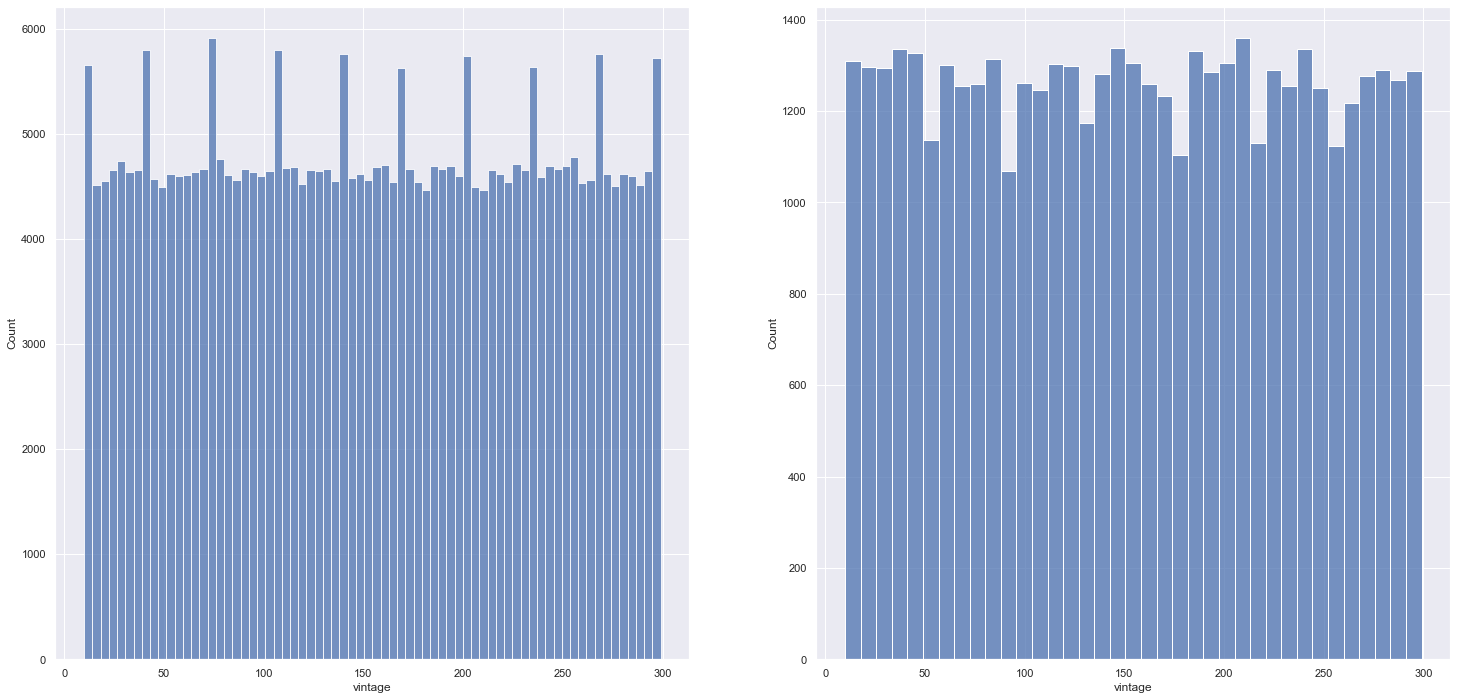

In [44]:
aux1 = df4.loc[df4['response'] == 0, 'vintage']
plt.subplot (1,2,1)
sns.histplot( aux1 )

aux2 = df4.loc[df4['response'] == 1, 'vintage']
plt.subplot (1,2,2)
sns.histplot( aux2 )

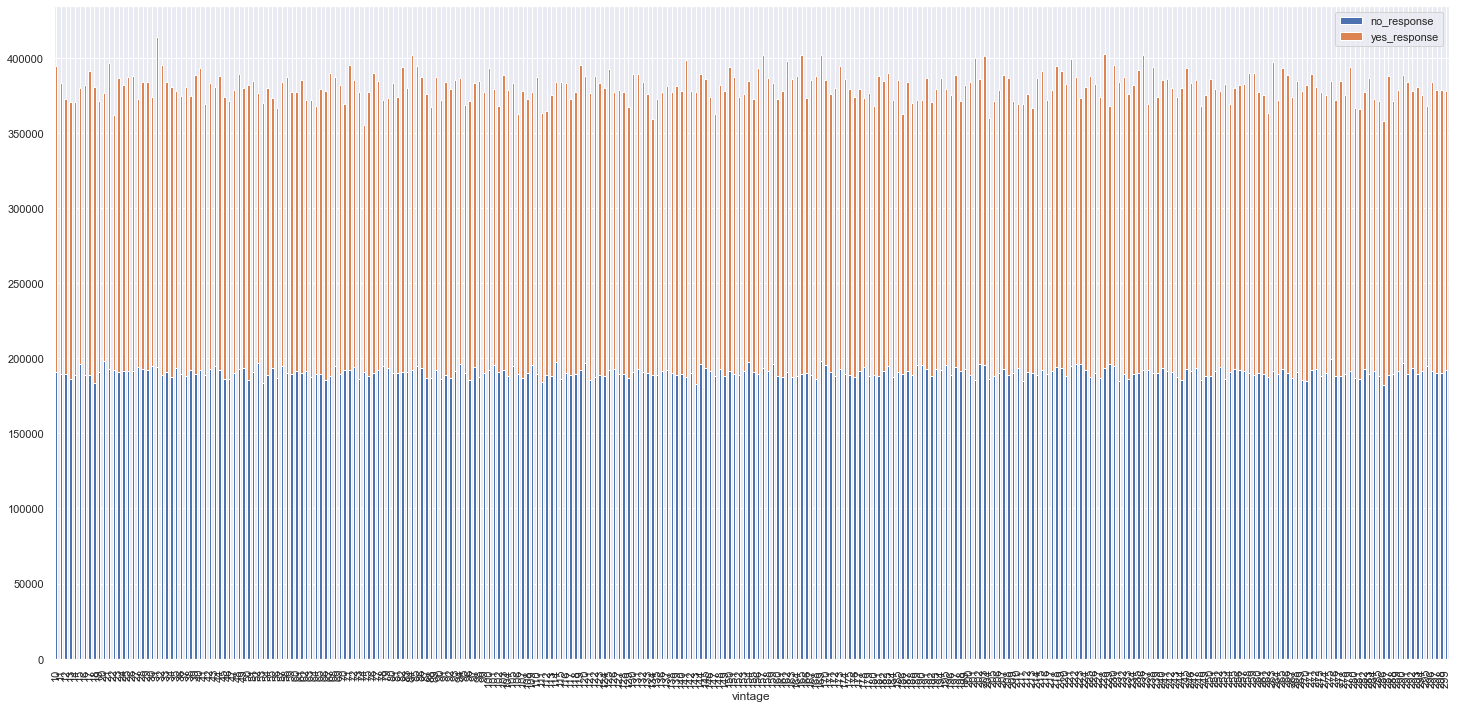

In [45]:
df = pd.pivot_table( index='vintage', columns='response', values='id', data=df4).reset_index()
df.columns = ['vintage', 'no_response', 'yes_response']
df.plot( x='vintage', kind='bar', stacked=True);

### **H8.** Pessoas sem carta de motorista tendem a nao querer o seguro de carro.


**TRUE** Pessoas sem carta de motorista tendem a nao querer o seguro de carro.

C:\Users\Djalma.junior\Anaconda3\envs\health-insurance-cross-sell\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


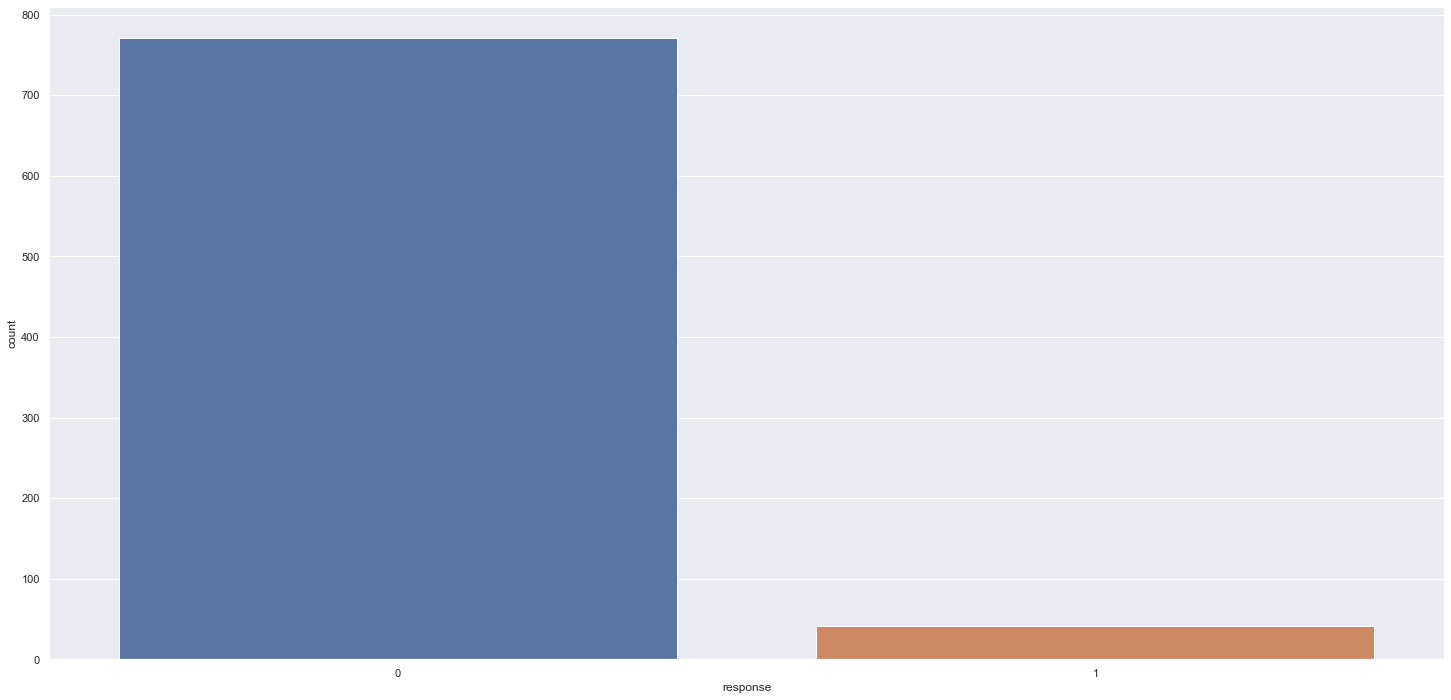

In [46]:
aux = df4.loc[df4['driving_license'] == 0 ]['response']
sns.countplot(aux);

In [47]:
# 5.2.1. Hypotheses Relevance
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1 - Mulheres estão mais propensas a contratar seguros de carro.', 'False', 'Medium'],  
      ['H2 - A Faixa de Meia-idade tem maior a possibilidade de contratar um seguro de carro.', 'True', 'High'],  
      ['H3 - O local de residência influi na decisão de contratar um seguro de carro.', 'True', 'Low'],
      ['H4 - Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.', 'True', 'High'],
      ['H5 - Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.', 'False', 'Medium'],
      ['H6 - Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.', 'False', 'Low'],
      ['H7 - Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.', 'False', 'Low'],
      ['H8 - Pessoas sem carta de motorista tendem a nao querer o seguro de carro.', 'True', 'High'],
    ]  

print(tabulate(tab, headers='firstrow', tablefmt = 'fancy_grid'))

╒══════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤═════════════╕
│ Hypothesis                                                                                               │ Conclusion   │ Relevance   │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪═════════════╡
│ H1 - Mulheres estão mais propensas a contratar seguros de carro.                                         │ False        │ Medium      │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H2 - A Faixa de Meia-idade tem maior a possibilidade de contratar um seguro de carro.                    │ True         │ High        │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H3 - O local de residência influ

## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

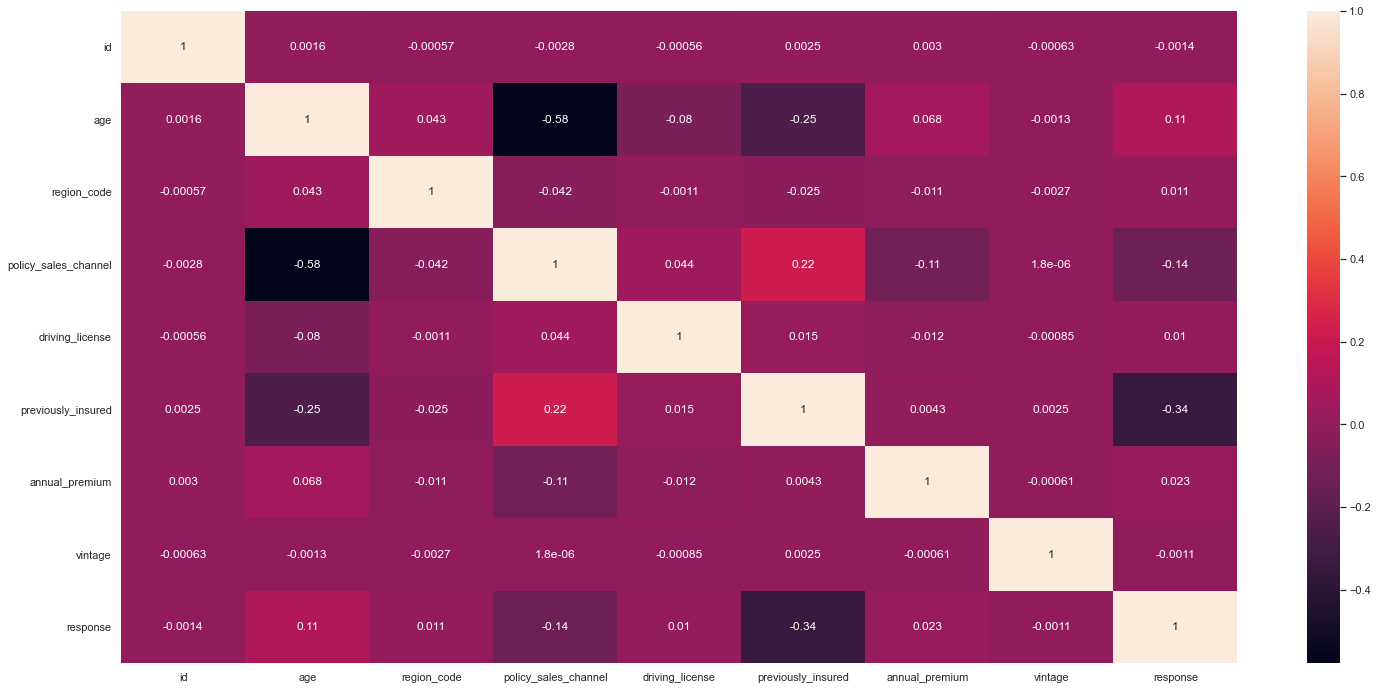

In [48]:
correlation=num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

### 4.3.2. Categorical Attributes


<AxesSubplot:>

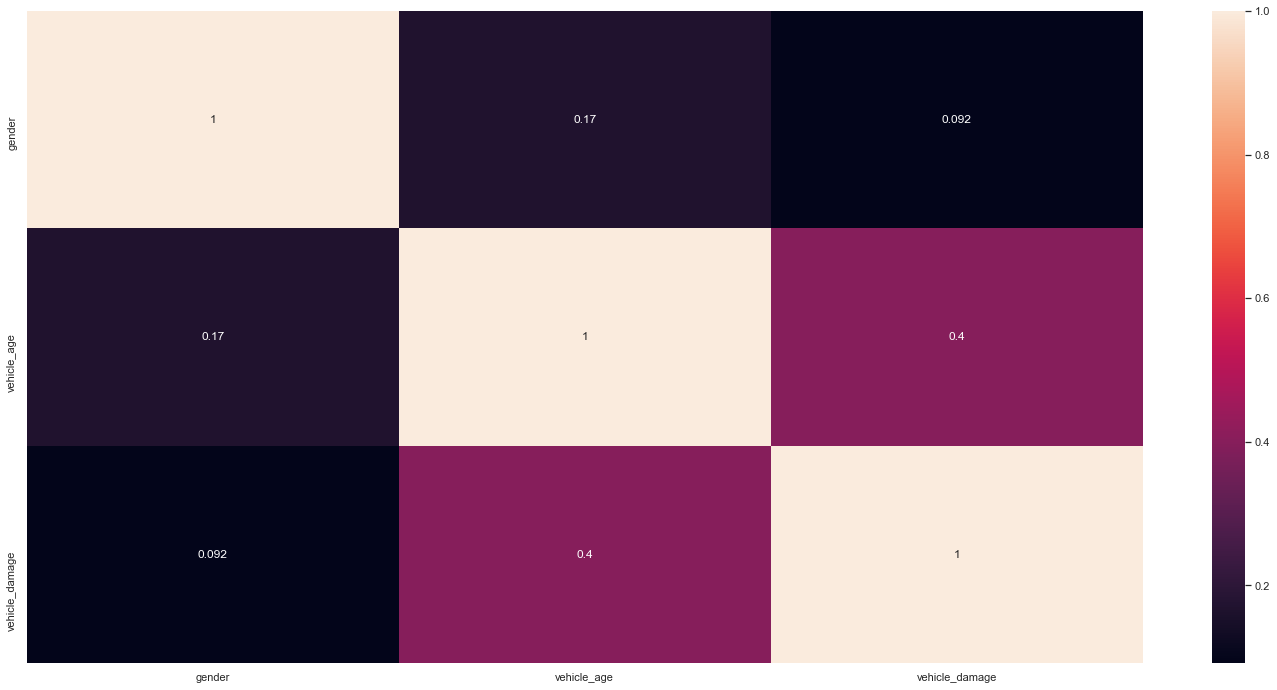

In [49]:
a = cat_attributes

# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )

a4 = cramer_v( a['vehicle_age'], a['gender'] )
a5 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a6 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )

a7 = cramer_v( a['vehicle_damage'], a['gender'] )
a8 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a9 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
                   'vehicle_age': [a4, a5, a6],
                   'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 PREPARACAO DE DADOS


In [50]:
df5=df4.copy()

In [51]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [52]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
225769,225769,Female,41,8.0,157.0,1,btw_1_2_years,1,0,59339.0,47,0
360195,360195,Female,52,28.0,160.0,1,btw_1_2_years,1,0,27297.0,165,0
54371,54371,Male,58,3.0,160.0,1,btw_1_2_years,1,0,25095.0,208,0
116992,116992,Female,55,28.0,122.0,1,btw_1_2_years,1,0,32558.0,200,0
171566,171566,Female,35,28.0,154.0,1,btw_1_2_years,0,1,31028.0,96,0


## 5.1 Standardization

In [53]:
scaler = StandardScaler()
df5['annual_premium'] = scaler.fit_transform(df5[['annual_premium']].values)
pickle.dump(scaler, open('/Users/Djalma.junior/DS/PA4/data_prep/annual_premium_scaler.pkl', 'wb' ))

##  5.2 Rescaling


In [54]:
a=df5.select_dtypes(include=['int64','float64'])

In [55]:
a.head()

,id,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response
225769,225769,41,8.0,157.0,1,1,0,1.670913,47,0
360195,360195,52,28.0,160.0,1,1,0,-0.189221,165,0
54371,54371,58,3.0,160.0,1,1,0,-0.317054,208,0
116992,116992,55,28.0,122.0,1,1,0,0.116196,200,0
171566,171566,35,28.0,154.0,1,0,1,0.027375,96,0


C:\Users\Djalma.junior\Anaconda3\envs\health-insurance-cross-sell\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age'>

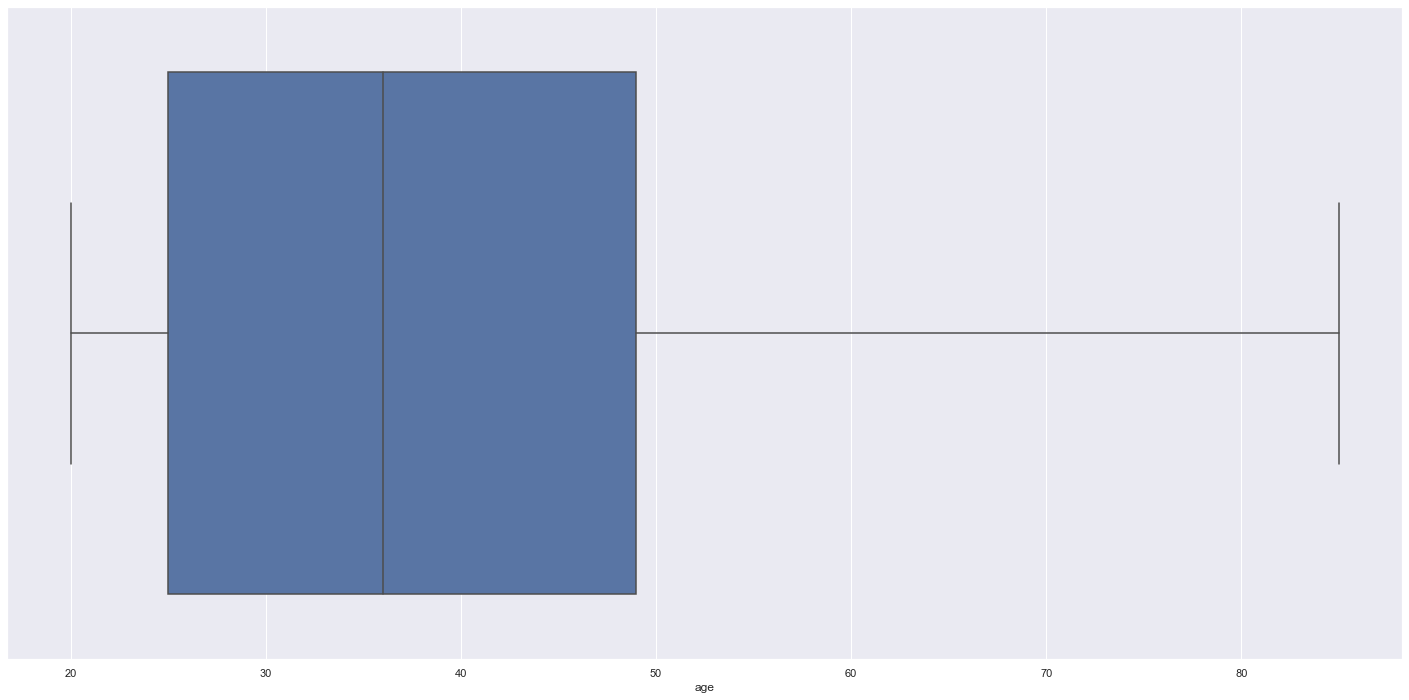

In [56]:
sns.boxplot(df5['age'])

In [57]:
# sem outliers entao MinMaxScaler para Age e Vintage

# age
A_mms = MinMaxScaler()
df5['age']=A_mms.fit_transform(df5[['age']].values)
pickle.dump(A_mms, open('/Users/Djalma.junior/DS/PA4/data_prep/age_scaler.pkl', 'wb' ))

# Vintage
V_mms = MinMaxScaler()
df5['vintage']=V_mms.fit_transform(df5[['vintage']].values)
pickle.dump(V_mms, open('/Users/Djalma.junior/DS/PA4/data_prep/vintage_scaler.pkl', 'wb' ))


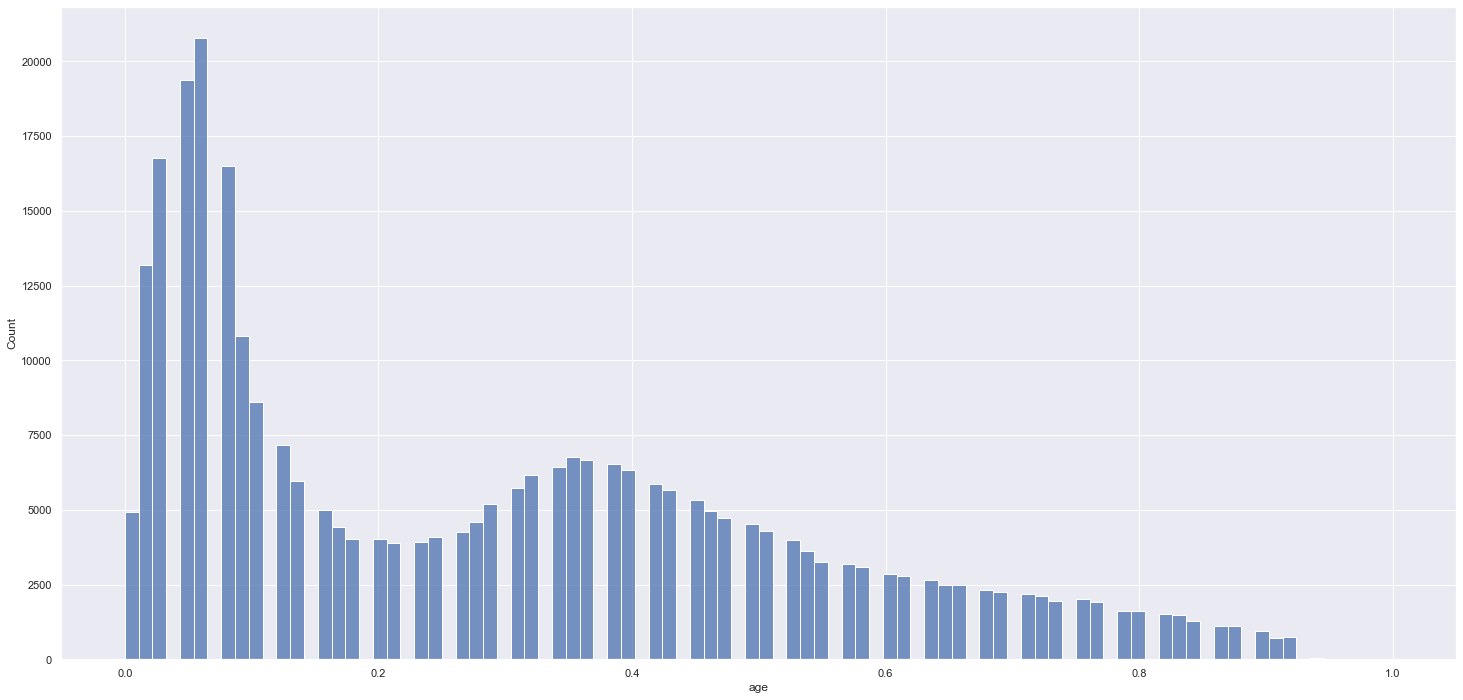

In [58]:
sns.histplot(df5['age']);

## 5.3 Transformation


In [59]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
225769,225769,Female,0.323077,8.0,157.0,1,btw_1_2_years,1,0,1.670913,0.128028,0
360195,360195,Female,0.492308,28.0,160.0,1,btw_1_2_years,1,0,-0.189221,0.536332,0
54371,54371,Male,0.584615,3.0,160.0,1,btw_1_2_years,1,0,-0.317054,0.685121,0
116992,116992,Female,0.538462,28.0,122.0,1,btw_1_2_years,1,0,0.116196,0.657439,0
171566,171566,Female,0.230769,28.0,154.0,1,btw_1_2_years,0,1,0.027375,0.297578,0


### 5.3.1 Encoding

In [60]:
# gender
# one hot encoding
df5=pd.get_dummies(df5,prefix=['gender'],columns=['gender'])


                   
# region code
# target encoding
tg_region_code=df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(tg_region_code)
pickle.dump(tg_region_code, open('/Users/Djalma.junior/DS/PA4/data_prep/region_code_scaler.pkl', 'wb' ))


#policy_sales_channel
# frequency encoding
# pego quantas vezes se repetiram e divido pelo meu ds
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('/Users/Djalma.junior/DS/PA4/data_prep/policy_sales_channel_scaler.pkl', 'wb' ))


# vehicle_age
# one hot encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

## 5.4 Validation Prep

In [61]:
# gender
x_validation.loc[:, 'gender'] =  pd.get_dummies( x_validation, prefix='gender', columns=['gender'] )

# age
x_validation.loc[:, 'age'] = A_mms.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( tg_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation , prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = scaler.fit_transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = V_mms.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

C:\Users\Djalma.junior\Anaconda3\envs\health-insurance-cross-sell\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
C:\Users\Djalma.junior\Anaconda3\envs\health-insurance-cross-sell\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Djalma.junior\Anaconda3\envs\health-insurance-cross-sell\lib\site-packages\pandas\

# 6.0  FEATURE SELECTION

In [62]:
df6=df5.copy()

## 6.1 Boruta Feature Selector

In [63]:
# #retirar minhas variaveis respostas
# x_train_n = df6.drop( ['id', 'response'], axis=1 ).values
# #ravel guarda valores em vetor
# y_train_n = y_train.values.ravel()


# # Define model
# et = en.ExtraTreesClassifier( n_jobs=-1 )
# # n_jobs utiliza todos os nucleos do pc

# # Define boruta
# boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

In [64]:
# #support valor do rank
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = df5.drop( ['id', 'response'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
# cols_selected_boruta foi a 'age'

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2 Feature Importance

In [65]:
# Building the model
forest_et =ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_et = df6.drop( ['id', 'response'], axis=1 )
y_train_et = y_train.values
forest_et.fit( x_train_et, y_train_et )

# Computing the importance of each feature
feature_importance = forest_et.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in forest_et.estimators_], axis = 0)

# rank
rank_ft = numpy.argsort(feature_importance)[::-1]#

Feature ranking:
                     feature  importance
0                    vintage    0.271825
0             annual_premium    0.244693
0                        age    0.167442
0                region_code    0.105834
0             vehicle_damage    0.065016
0       policy_sales_channel    0.061921
0         previously_insured    0.058699
0    vehicle_age_less_1_year    0.013366
0  vehicle_age_btw_1_2_years    0.006686
0   vehicle_age_over_2_years    0.002278
0              gender_Female    0.000917
0                gender_Male    0.000838
0            driving_license    0.000487


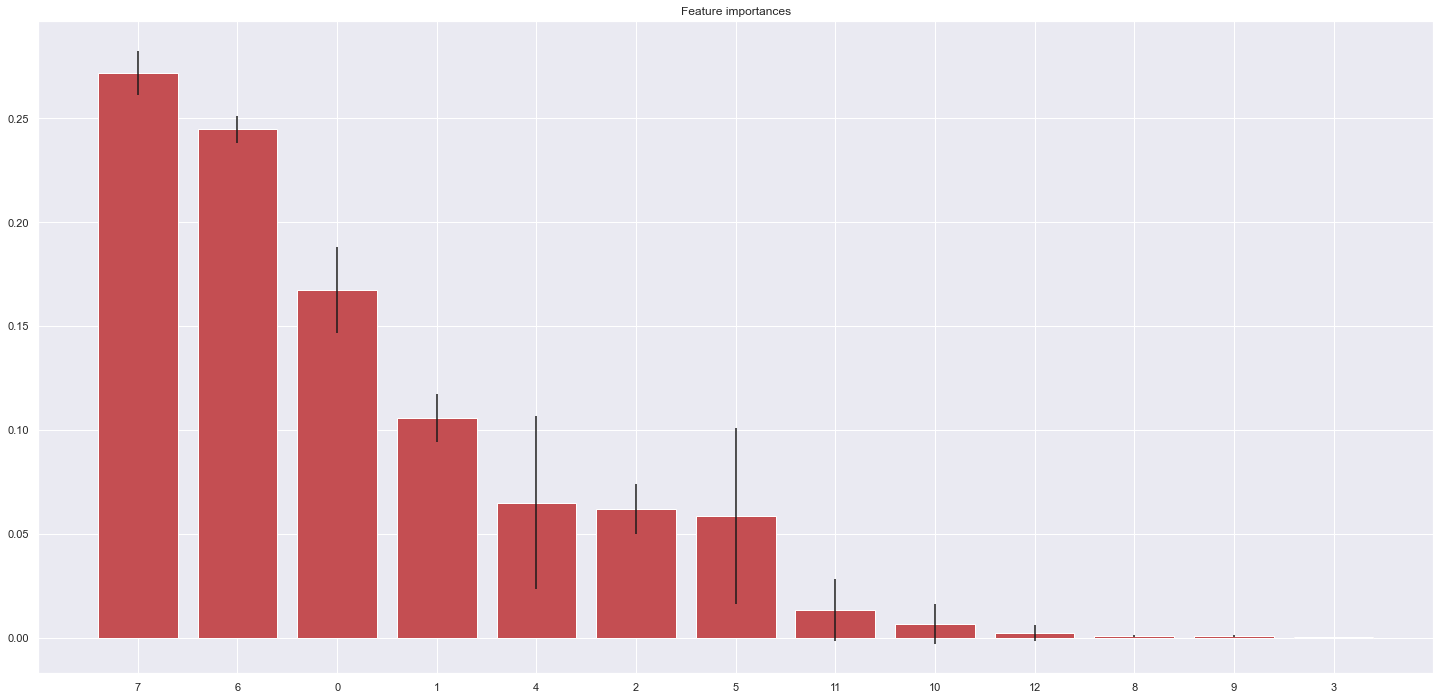

In [66]:
# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_et, forest_et.feature_importances_ ):
                aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
                df = pd.concat( [df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_et.shape[1]), feature_importance[rank_ft], color="r", yerr=feature_importance_normalized[rank_ft], align="center")
plt.xticks(range(x_train_et.shape[1]), rank_ft)
plt.xlim([-1, x_train_et.shape[1]])
plt.show()

# 7.0 MACHINE LEARNING


In [67]:
df7 = df6.copy()

cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']  



#df5 is where my train features are, and only catch my columns selected
# x_train = df5[ cols_selected ]
x_train = df7[ cols_selected ]


# x validation is on 5.4 (validation prep)
x_validation = x_validation[ cols_selected ]

# y_validation its on 5.0 split
Y_vali = y_validation.copy()

model_rank = pd.DataFrame(columns={'Model':[], "Precision_at_k": [], "Recall_at_k": []})

In [68]:
df100 = x_train.copy()

## 7.1. KNN Classifier

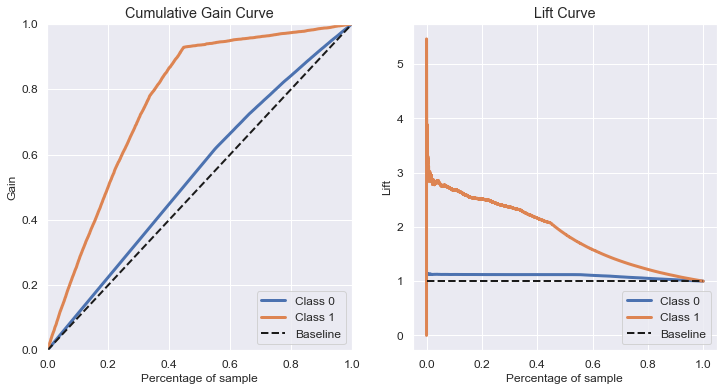

In [69]:
# model definition
model_knn = nh.KNeighborsClassifier( n_neighbors=10 ).fit( x_train, y_train )

# model prediction - generalizacao do modelo e nao o de aprendizado
yhat_proba_knn = model_knn.predict_proba( x_validation )

model_rank_1 = model_results (model_knn, "KNN Classifier", df7, 20000 )

## 7.2 Logistic Regression

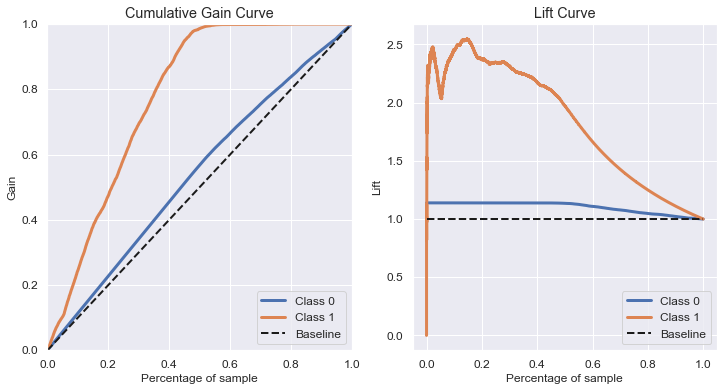

In [70]:
# model definition
model_reglog = LogisticRegression(penalty='l2', solver='newton-cg').fit(x_train,y_train)

# model prediction - generalizacao do modelo e nao o de aprendizado
yhat_proba_reglog = model_reglog.predict_proba(x_validation)

model_rank_2 = model_results (model_reglog, "Logistic Regression Classifier", df7, 20000 )



## 7.3. Extra Trees Classifier



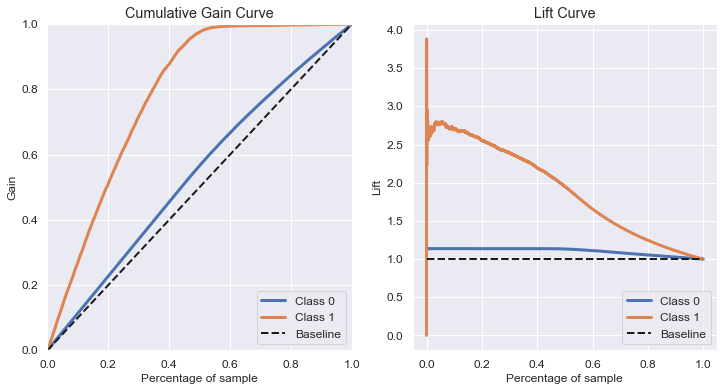

In [71]:
# model definition
model_et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# model prediction
yhat_proba_et = model_et.predict_proba( x_validation )

model_rank_3 = model_results (model_et, "Extra Trees Classifier", df7, 20000 )


## 7.4. Random Forest 

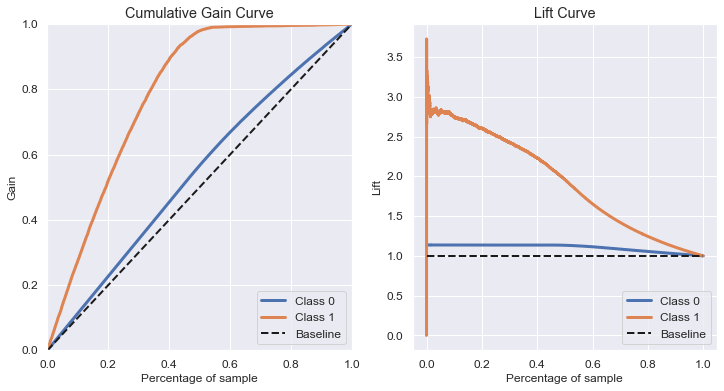

In [72]:
# model definition
model_rf = en.RandomForestClassifier(n_estimators=100,random_state=42).fit(x_train,y_train)

# model prediction
yhat_proba_rf = model_rf.predict(x_validation)

model_rank_4 = model_results (model_rf, "Random Forest Classifier", df7, 20000 )


## 7.5 XGBoost 

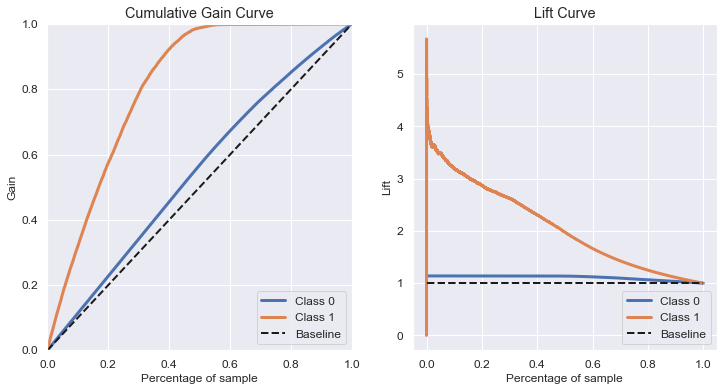

In [73]:
# model definition
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              n_jobs=-1,
                              subsample=0.7,
                              colsample_bytree=0.9,
                              verbosity=0).fit(x_train,y_train)

# model prediction
yhat_proba_xgb = model_xgb.predict_proba(x_validation)

model_rank_5 = model_results (model_xgb, "XGBoost Classifier", df7, 20000 )

## 7.6 Naive Bayes Classifier model

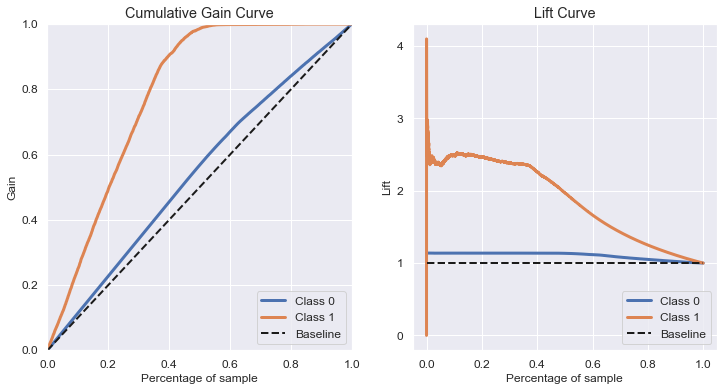

In [74]:
# model definition
model_nbc = GaussianNB().fit(x_train,y_train)


# model prediction
yhat_proba_xgb = model_nbc.predict_proba(x_validation)


model_rank_6 = model_results (model_nbc, "Naive Bayes Classifier", df7, 20000 )

## 7.7 Light Gradient Boosting Machine Classifier model

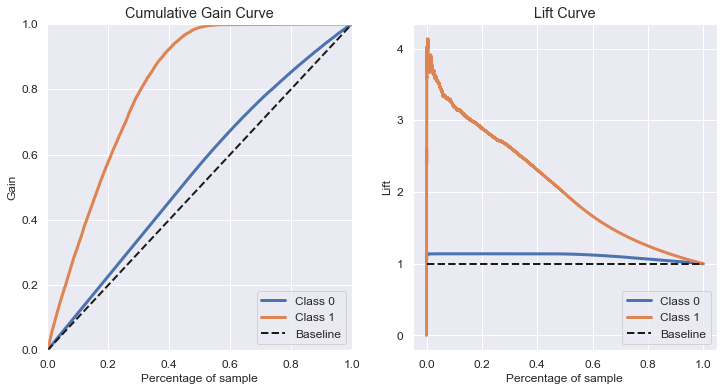

In [75]:
# model definition
model_lgbm = LGBMClassifier().fit(x_train,y_train)

# model prediction
yhat_proba_lgbm = model_lgbm.predict_proba(x_validation)

model_rank_7 = model_results (model_lgbm, "LGBM Classifier", df7, 20000 )



## 7.9 Compare Model's Performance

### 7.9.1. Single Performance

In [76]:
res_total = pd.concat([model_rank_1, model_rank_2, model_rank_3, model_rank_4, model_rank_5, model_rank_6, model_rank_7], axis=0)
res_total.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)


,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.331233,0.712595
1,XGBoost Classifier,0.330333,0.710659
2,Random Forest Classifier,0.304285,0.654620
3,Extra Trees Classifier,0.297985,0.641067
4,KNN Classifier,0.294685,0.633968
5,Naive Bayes Classifier,0.293535,0.631494
6,Logistic Regression Classifier,0.285786,0.614822


### 7.9.2. Real Performance - Cross Validation

In [77]:
# models_performance_cv = pd.DataFrame({'Model':[], 'Precision_at_k': [], 'Recall_at_k': []}) 

# models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'KNN CV', model_knn, x_train, y_train, 20000)
# models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'LR CV',  model_reglog, x_train, y_train, 20000) 
# models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'ET CV',  model_et, x_train, y_train, 20000) 
# models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'RF CV',  model_rf, x_train, y_train, 20000) 
# models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'XGB CV', model_xgb, x_train, y_train, 20000) 
# models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'NBC CV', model_nbc, x_train, y_train, 20000) 
# models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'LGBM CV', model_lgbm, x_train, y_train, 20000) 


# models_performance_cv = models_performance_cv.sort_values('Precision_at_k', ascending = False).reset_index(drop=True)
# pickle.dump( models_performance_cv, open( '/Users/Djalma.junior/DS/PA4/cv/cross_validation.pkl', 'wb' ) )
# models_performance_cv

In [78]:
models_performance_cv = pickle.load( open( '/Users/Djalma.junior/DS/PA4/cv/cross_validation.pkl', 'rb' ) )

models_performance_cv

,Model,Precision_at_k,Recall_at_k
0,LGBM CV,0.311 +/- 0.001,0.83 +/- 0.002
1,XGB CV,0.309 +/- 0.001,0.827 +/- 0.002
2,RF CV,0.293 +/- 0.002,0.783 +/- 0.005
3,NBC CV,0.291 +/- 0.001,0.776 +/- 0.003
4,ET CV,0.29 +/- 0.002,0.774 +/- 0.005
5,KNN CV,0.285 +/- 0.002,0.762 +/- 0.005
6,LR CV,0.277 +/- 0.002,0.74 +/- 0.006


# 8.0. HYPERPARAMETER FINE TUNING

In [79]:
df8 = df7.copy()

## 8.1 XGB TUNING

In [80]:
# param = {'n_estimators':[2000, 2500, 3000, 3500],
#          'eta':[0.01, 0.03],
#          'gamma':[3, 10, 20],
#          'max_depth':[3, 5, 9],
#          'subsample':[0.1, 0.5, 0.7],
#          'colsample_bytree':[0.3, 0.7, 0.9],
#          'min_child_weight':[3, 8, 15],
#         }

# MAX_EVAL = 5

# # final_result = pd.DataFrame()
# hyperparam_lst = []

# for i in range(MAX_EVAL):
#     #randomly selected hyperparameters
#     hp = {k:rd.sample(v, 1)[0] for k, v in param.items()}
#     #print the selected ones
#     print(hp)
    
#     #model
#     model_xgb = xgb.XGBClassifier(objective='binary:logistic',
#                                   use_label_encoder=False,
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   gamma=hp['gamma'],
#                                   max_depth=hp['max_depth'],
#                                   n_jobs=-1,
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'],
#                                   verbosity=0)
    
#     result = cross_validation (df7, final_result, 5, 'XGB Classifier', model_xgb, x_train, y_train, 20000) 
#     iter_nr = pd.Series([i], name='Iter_nr')
#     result_w_nr = pd.concat([result, iter_nr], axis=1)
#     final_result = pd.concat([final_result, result_w_nr], ignore_index=True)




# final_result.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)
# final_result

# pickle.dump( final_result, open( '/Users/Djalma.junior/DS/PA4/cv/xgb_tuning.pkl', 'wb' ) )


## 8.2 LGBM TUNING 

In [82]:
lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),          
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

MAX_EVAL = 5


for i in range(MAX_EVAL):
    #randomly selected hyperparameters
    hp = {k:rd.sample(v, 1)[0] for k, v in lgbm_parameter.items()}
    #print the selected ones
    print(hp)
    #model
    model_lgbm=LGBMClassifier(  objective = 'binary',
                                num_leaves=hp['num_leaves'],
                                max_depth=hp['max_depth'],
                                min_split_gain=hp['min_split_gain'],
                                subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'])
    
    result = cross_validation (df7, final_result_lg, 5, 'LGBM Classifier', model_lgbm, x_train, y_train, 20000) 
    iter_nr = pd.Series([i], name='Iter_nr')
    result_w_nr = pd.concat([result, iter_nr], axis=1)
    final_result_lg = pd.concat([final_result_lg, result_w_nr], ignore_index=True)


final_result_lg.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)
final_result_lg

pickle.dump( final_result_lgbm, open( '/Users/Djalma.junior/DS/PA4/cv/lgbm_tuning_10.pkl', 'wb' ) )


{'num_leaves': 15, 'max_depth': 10, 'min_split_gain': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.1}


<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{'num_leaves': 45, 'max_depth': 5, 'min_split_gain': 0.001, 'subsample': 0.5, 'colsample_bytree': 0.1}


<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{'num_leaves': 60, 'max_depth': 7, 'min_split_gain': 0.01, 'subsample': 1, 'colsample_bytree': 0.1}


<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.1, 'subsample': 1, 'colsample_bytree': 1}


<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.1, 'subsample': 1, 'colsample_bytree': 1}


<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-2-a43ccf1eaecb>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

NameError: name 'final_result_lgbm' is not defined

In [84]:
# como colocar os param em lista
#param_tuned = 'num_leaves': 60, 'max_depth': 10, 'min_split_gain': 0.001, 'subsample': 0.5, 'colsample_bytree': 1

final_result_lgbm = pickle.load( open( '/Users/Djalma.junior/DS/PA4/cv/lgbm_tuning_10.pkl', 'rb' ) )

final_result_lgbm

,Model,Precision_at_k,Recall_at_k,Iter_nr
0,LGBM Classifier,0.305 +/- 0.0,0.814 +/- 0.0,0
1,LGBM Classifier,0.305 +/- 0.0,0.814 +/- 0.001,1
2,LGBM Classifier,0.311 +/- 0.0,0.832 +/- 0.002,2
3,LGBM Classifier,0.305 +/- 0.0,0.814 +/- 0.001,3
4,LGBM Classifier,0.311 +/- 0.001,0.83 +/- 0.002,4


In [ ]:
final_result_lgbm = pickle.load( open( '/Users/Djalma.junior/DS/PA4/cv/lgbm_tuning_1.pkl', 'rb' ) )

final_result_lgbm

## 8.3 Final Model

In [ ]:
# #model
# model_xgb = xgb.XGBClassifier(objective='binary:logistic',
#                               use_label_encoder=False,
#                               n_estimators=2000,
#                               eta=0.01,
#                               gamma=20,
#                               max_depth=3,
#                               n_jobs=-1,
#                               subsample=0.1,
#                               colsample_bytree=0.7,
#                               min_child_weight=15,
#                               verbosity=0).fit(x_train,y_train)

# xgb_tuned_20k = model_results (model_xgb, "XGBoost Classifier", df7, 20000 )

# # model prediction
# yhat_xgb_tuned = model_xgb.predict_proba(x_validation)


# xgb_tuned_20k

# xgb_tuned_40k = model_results (model_xgb, "XGBoost Classifier", df7,40000 )

# xgb_tuned_40k

# xgb_tuned_call80 = model_results (model_xgb, "XGBoost Classifier", df7,23957 )

# xgb_tuned_call80

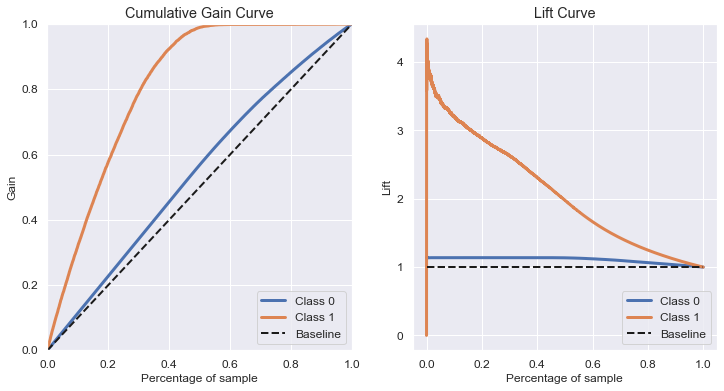

In [110]:
#model
model_lgbm_tuned=LGBMClassifier(  objective = 'binary',
                                num_leaves=60,
                                max_depth=10,
                                min_split_gain=0.001,
                                subsample=0.5,
                                colsample_bytree=1).fit(x_train,y_train)

lgbm_tuned_20k = model_results (model_lgbm_tuned, "LGBM Classifier", df7, 20000 )

# model prediction
yhat_lgbm_tuned = model_lgbm.predict_proba(x_validation)


lgbm_tuned_20k


pickle.dump(model_lgbm_tuned, open ('/Users/Djalma.junior/DS/PA4/cv/lgbm_tuned.pkl', 'wb' ))

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.231044,0.994084


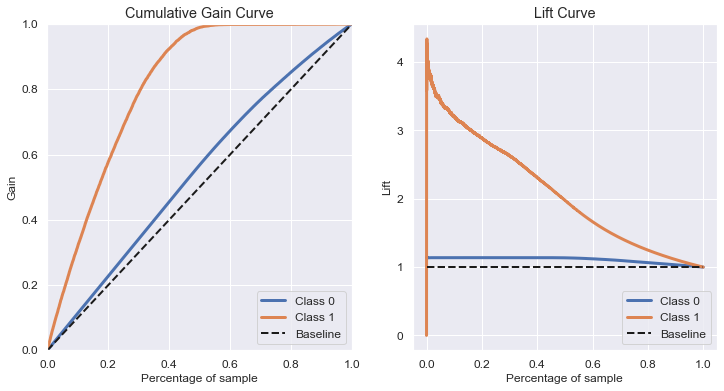

In [111]:
lgbm_tuned_40k = model_results (model_lgbm_tuned, "LGBM Classifier", df7,40000 )

lgbm_tuned_40k

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.319051,0.800151


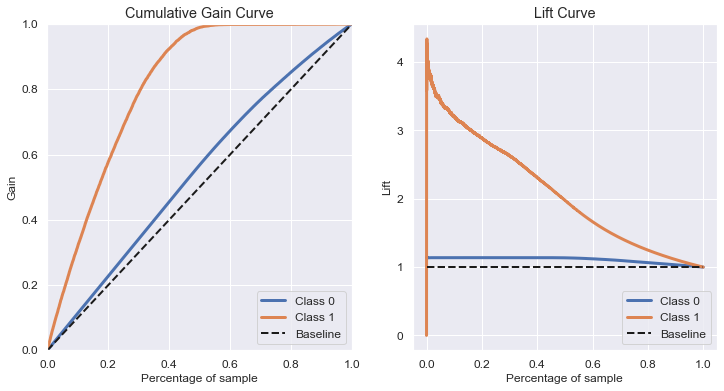

In [117]:
xgb_tuned_call80 = model_results (model_lgbm_tuned, "LGBM Classifier", df7,23315 )
xgb_tuned_call80

In [125]:
print('XGB object size: {0:.2f} KB'.format(os.stat('/Users/Djalma.junior/DS/PA4/cv/xgb_tuning.pkl').st_size/1024))
print('LGBM object size: {0:.2f} KB'.format(os.stat('/Users/Djalma.junior/DS/PA4/cv/lgbm_tuned.pkl').st_size/1024))

XGB object size: 1.15 KB
LGBM object size: 644.74 KB
